# Woche 1 – Checklist & Roadmap
This week is all about setting up your workspace and reducing the raw data to a manageable portion with a focus on the Guayas province.

## Load Data 

In [1]:
# vorabladen der Kleinen dateien
import pandas as pd
import os

data_path = "Sempel_data"

df_holiday_events = pd.read_csv(os.path.join(data_path, "holiday_events.csv"))
df_items = pd.read_csv(os.path.join(data_path, "items.csv"))
df_oil = pd.read_csv(os.path.join(data_path, "oil.csv"))
df_stores = pd.read_csv(os.path.join(data_path, "stores.csv"))
df_transactions = pd.read_csv(os.path.join(data_path, "transactions.csv"))

print("All smaller csv files loaded successfully.")

All smaller csv files loaded successfully.


In [2]:
# Pattern: Load and slim down the main file (Guayas filtering and downsampling to 300000)
import pandas as pd
import os

data_path = "Sempel_data"
train_csv_path = os.path.join(data_path, "train.csv")

chunk_size = 10**6
filtered_chunks = []

# 1. Filter Store_IDs for Guayas
# df_stores must already be loaded!
guayas_stores = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# 2. Load and filter train.csv in chunks
for chunk in pd.read_csv(train_csv_path, chunksize=chunk_size):
    chunk_filtered = chunk[chunk['store_nbr'].isin(guayas_stores)]
    filtered_chunks.append(chunk_filtered)

df_train_guayas = pd.concat(filtered_chunks)

# 3. Downsampling by percentage (0.01% for minimal testing)
df_train = df_train_guayas.sample(n=min(300000, len(df_train_guayas)), random_state=42).copy()

# CORRECTION: Convert 'date' column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

print("train.csv processed successfully.")
print(f"Original Guayas rows (approx.): {df_train_guayas.shape[0]}")
print(f"Final dataframe df_train shape (0.01% Sample): {df_train.shape}")
print(f"✅ df_train now contains {df_train.shape[0]} rows. The large DataFrame has been overwritten.")
df_train.head()

/var/folders/k8/7_ysp8813gz5xdcks_1dkqw40000gn/T/ipykernel_83719/3725844256.py:16: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(train_csv_path, chunksize=chunk_size):


train.csv processed successfully.
Original Guayas rows (approx.): 22941656
Final dataframe df_train shape (0.01% Sample): (300000, 6)
✅ df_train now contains 300000 rows. The large DataFrame has been overwritten.


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
36402992,36402992,2014-12-01,26,1696038,2.234,False
40318340,40318340,2015-01-31,27,804974,18.000,False
2631489,2631489,2013-03-06,51,838216,45.000,NaN
24252889,24252889,2014-05-23,27,207857,6.000,False
46434803,46434803,2015-05-10,29,679926,4.000,False


## Data Exploration & Feature Engineering (follow the same procedure as in the lectures, but now apply it to Guayas)

- Data Quality Checks
  - Missing Values: Detect and handle null values in each column.
  - Missing Calendar Days: Create a full daily index for each (store, item) and fill missing days with unit_sales = 0.
  - Outliers: Check for impossible negative values or extreme spikes in unit_sales; trim, replace, or flag if necessary.

In [3]:
# ⚙️ Analyse der Daten Type / Unique(count)/ Duplicate (count) / NaN / Ausreisser (Unverändertes Muster zur Analyse)
import pandas as pd
import numpy as np
import warnings
import re 
from typing import Dict, List, Callable, Union

# --- ANZEIGEEINSTELLUNGEN ---
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Zuweisung für das Muster
df_check = df_train

def generate_cleaning_muster(column: str, semantic_type: str) -> str:
    # Platzhalter
    return ""

def count_special_chars(text: Union[str, any]) -> int:
    if isinstance(text, str):
        # Gezählt werden alle Zeichen außer Buchstaben, Zahlen und Leerzeichen
        return len(re.findall(r'[^a-zA-Z0-9\s]', text)) 
    return 0

def analyze_semantic_type_v4(df_check: pd.DataFrame) -> pd.DataFrame:
    """
    Klassifiziert die semantischen Datentypen der Spalten (aus Muster2).
    """
    SEMANTIC_HINTS_PRIORITY: Dict[str, Dict[str, Union[set, Callable]]] = {
        'ID': {
            'keywords': {'_id', 'session_id', 'trip_id', 'user_id', 'unique_id', 'kundennummer', 'bestellnr', 'order_id', 'artikelnummer', 'store_nbr', 'item_nbr'},
            'validation_func': lambda series: ((series.dropna().astype(str).apply(len) >= 3).any())
        },
        'Datum/Zeit': {
            'keywords': {'datum', 'zeit', 'date', 'time', 'start', 'end', 'birthdate', 'signup_date', 'check_in', 'check_out', 'departure', 'return', 'geburtstag', 'timestamp', 'creation_date', 'modified_date', 'erstellt', 'week'},
            'validation_func':lambda series: ((series.dropna().nunique() == 12 or series.dropna().nunique() == 31) or (series.dropna().apply(lambda x: isinstance(x, str)).all() and (pd.to_datetime(series.dropna(), errors='coerce').notna().all() or (series.dropna().astype(str).str.contains(r'[-_/]', na=False).any() and series.dropna().astype(str).str.contains(r'\d{4}', na=False).any())))) or (pd.api.types.is_datetime64_any_dtype(series))
        },
        'Datum/Zeit(int)': {
            'keywords': {'month','week','day'},
            'validation_func': lambda series: (series.dropna().nunique() == 12 or 6 <= series.dropna().nunique() <= 7 or series.dropna().nunique() == 31)
        },
        'Geometrisch': {
            'keywords': {'geom', 'geometry', 'shape', 'wkt', 'geojson', 'coordinates', 'location_data'},
            'validation_func': lambda series: (series.dropna().astype(str).str.contains(r'^(POINT|LINESTRING|POLYGON|MULTIPOINT|MULTILINESTRING|MULTIPOLYGON)\s*\(', regex=True, na=False).any() or series.dropna().astype(str).str.contains(r'{"type":\s*"(Point|LineString|Polygon|MultiPoint|MultiLineString|MultiPolygon)"', regex=True, na=False).any())
        },
    }
    SEMANTIC_HINTS_TEXT: Dict[str, Dict[str, Union[set, Callable]]] = {
        'Text (Kategorisch)': {
            'keywords': {'city', 'country', 'länder', 'region', 'state', 'bundesland', 'zip', 'plz', 'family'},
            'validation_func': lambda series: series.dropna().nunique() >= 2 and (pd.api.types.is_string_dtype(series.dropna()) or isinstance(series.dropna().dtype, pd.CategoricalDtype))
        },
         'Text (Gender)': {
            'keywords': {'geschlecht', 'typ', 'category', 'art', 'gender'},
            'validation_func': lambda series: series.dropna().nunique() >= 2 and (pd.api.types.is_string_dtype(series.dropna()) or isinstance(series.dropna().dtype, pd.CategoricalDtype))
        },
        'Text (object)': {
            'keywords': {'sales_method', 'airport', 'destination', 'origin', 'heimat', 'status'},
            'validation_func': lambda series: series.dropna().nunique() >= 2 and (pd.api.types.is_string_dtype(series.dropna()) or isinstance(series.dropna().dtype, pd.CategoricalDtype))
        },
        'Text (Freitext)': {
            'keywords': {'name', 'hotel', 'airline', 'beschreibung', 'kommentar', 'nachricht', 'adresse'},
            'validation_func': lambda series: pd.api.types.is_string_dtype(series.dropna()) or isinstance(series.dropna().dtype, pd.CategoricalDtype)
        },
    }
    SEMANTIC_HINTS_NUMERIC: Dict[str, Dict[str, Union[set, Callable]]] = {
        'Boolean(NaN)': {
            'keywords': {'is_invalid','missing', 'is_missing', 'has_value', 'exists', 'is_null', 'is_na', 'isnan', 'filled','is_outlier'},
            'validation_func': lambda series: (series.dropna().nunique() >= 1) and (pd.api.types.is_bool_dtype(series.dropna()) or set(series.dropna().astype(str).str.lower().str.strip().unique()).issubset({'true', 'false', '1', '0', 'ja', 'nein', 'yes', 'no', 't', 'f', 'wahr', 'falsch'}))
        },
        'Boolean': {
            'keywords': {'self_employed','is_weekend_trip', 'boolean', 'bool', 'booked', 'married', 'cancellation', 'children','discount', 'flight_booked', 'hotel_booked', 'return_flight_booked', 'is_cancelled', 'onpromotion'},
            'validation_func': lambda series: (series.dropna().nunique() <= 2) and (pd.api.types.is_bool_dtype(series.dropna()) or set(series.dropna().astype(str).str.lower().str.strip().unique()).issubset({'true', 'false', '1', '0', 'ja', 'nein', 'yes', 'no', 't', 'f', 'wahr', 'falsch'}))
        },
        'Float (Geografisch)': {
            'keywords': {'lat', 'lon', 'latitude', 'longitude'},
            'validation_func': lambda series: pd.to_numeric(series.dropna(), errors='coerce').notna().all() and (pd.to_numeric(series.dropna(), errors='coerce').astype(str).str.count(r'\.').all() or pd.api.types.is_float_dtype(series.dropna()))
        },
        'Float (Prozentsatz)': {
            'keywords': {'percent', 'pct', 'rate', 'discount', '%'},
            'validation_func': lambda series: (series.dropna().nunique() > 2) and ((pd.to_numeric(series.dropna().astype(str).str.replace('%', ''), errors='coerce').dropna().between(0, 1).all() or pd.to_numeric(series.dropna().astype(str).str.replace('%', ''), errors='coerce').dropna().between(0, 100).all()) or (pd.to_numeric(series.dropna().astype(str).str.replace('%', ''), errors='coerce').notna().all() and series.dropna().astype(str).str.replace('%', '').str.replace(',', '.').str.match(r'^\d{1,3}(\.\d{1,3})?$').all()))
        },
        'Float (Waehrung)': {
            'keywords': {'revenue','preis', 'kosten', 'betrag', 'dollar', 'euro', 'yen', 'usd', 'eur', 'fare','chf', 'gbp', 'sek', 'jpy', '€', '£', '$'},
            'validation_func': lambda series: (pd.api.types.is_numeric_dtype(series.dropna()) or pd.to_numeric(series.dropna().astype(str).str.replace(',', '.'), errors='coerce').notna().all()) and series.dropna().nunique() > 2
        },
        'Integer': {
            'keywords': {'nb_sold', 'years_as_customer', 'nb_site_visits', '_time_days', '_duration_days', 'anzahl', 'menge', 'stueck', 'stk', 'count', 'qty', 'seats', 'rooms', 'nights', 'bags', 'clicks', 'nummer', 'nr', 'quantity', 'val', 'rating', 'unit_sales'},
            'validation_func': lambda series: (series.dropna().nunique() > 2) and pd.to_numeric(series.dropna(), errors='coerce').notna().all() and (pd.to_numeric(series.dropna(), errors='coerce').dropna().apply(lambda x: x.is_integer() if isinstance(x, float) else True).all())
        }
    }
    results: List[Dict[str, str]] = []
    hint_categories = [SEMANTIC_HINTS_PRIORITY, SEMANTIC_HINTS_TEXT, SEMANTIC_HINTS_NUMERIC]
    SEMANTIC_HINTS_NUMERIC_ORDERED: List[str] = ['Boolean(NaN)','Boolean', 'Float (Geografisch)', 'Float (Prozentsatz)', 'Float (Waehrung)', 'Integer']

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", DeprecationWarning)
        warnings.simplefilter("ignore", UserWarning)

        df_to_analyze = df_check 

        for column in df_to_analyze.columns:
            original_dtype: str = str(df_to_analyze[column].dtype)
            semantic_type: str = original_dtype
            column_lower: str = column.lower()
            found_match: bool = False

            for hint_group in hint_categories:
                if found_match:
                    break
                if hint_group is SEMANTIC_HINTS_NUMERIC:
                    for sem_type in SEMANTIC_HINTS_NUMERIC_ORDERED:
                        hints = hint_group[sem_type]
                        name_match = any(keyword in column_lower for keyword in hints['keywords'])
                        content_valid = False
                        try:
                            content_valid = hints['validation_func'](df_to_analyze[column])
                        except Exception:
                            pass

                        if name_match and content_valid:
                            semantic_type = sem_type
                            found_match = True
                            break
                else:
                    for sem_type, hints in hint_group.items():
                        name_match = any(keyword in column_lower for keyword in hints['keywords'])
                        content_valid = False
                        try:
                            content_valid = hints['validation_func'](df_to_analyze[column])
                        except Exception:
                            pass

                        if name_match and content_valid:
                            semantic_type = sem_type
                            found_match = True
                            break

            results.append({
                'Spalte': column,
                'Semantischer_Typ': semantic_type,
            })

    return pd.DataFrame(results)

# HAUPT-MUSTER FÜR KONSOLIDIERTE ANZEIGE (INKL. SEMANTIK, OHNE VORSCHLÄGE)
def muster_df_consolidated_view(df: pd.DataFrame) -> None:
    """
    Führt eine konsolidierte Datenqualitäts-Analyse durch, inklusive der neuen 
    robusten Metriken für Feature Engineering (StdDev, Kardinalität, Z-Score-Ausreißer).
    """
    # 1. Semantische Typ-Erkennung
    df_sem_types = analyze_semantic_type_v4(df)
    
    # Dictionary zur Konsolidierung ALLER Metriken pro Spalte
    consolidated_data: Dict[str, Dict[str, Union[str, float, int, None]]] = {}

    # Initialisierung und Basis-Metriken
    for col in df.columns:
        sem_type_row = df_sem_types[df_sem_types['Spalte'] == col].iloc[0] if col in df_sem_types['Spalte'].values else {'Semantischer_Typ': str(df[col].dtype)}
        
        duplicate_count = len(df) - df[col].nunique()
        special_chars_count = df[col].astype(str).apply(count_special_chars).sum()
        
        # NEUE METRIK: Kardinalität (%)
        cardinality_ratio = round(df[col].nunique() / len(df) * 100, 2)
        
        consolidated_data[col] = {
            'Spalte': col,
            'Semantischer_Typ': sem_type_row['Semantischer_Typ'],
            'Datentyp': str(df[col].dtype),
            'Einzigartige_Werte': df[col].nunique(),
            'Kardinalität(%)': cardinality_ratio,
            'Duplicate': duplicate_count, 
            'NaN': df[col].isnull().sum(),
            'NaN(%)': round(df[col].isnull().sum() / len(df) * 100, 2),
            
            # Text-Metrik
            'Sonderzeichen ': special_chars_count,
            
            # Statistische und ML-Metriken (Standardmäßig NaN)
            'Min': np.nan, '25% (Q1)': np.nan, 'Median': np.nan, '75% (Q3)': np.nan, 
            'Max/100%(Q4)': np.nan, 
            'StdDev': np.nan, # NEU: Standardabweichung
            'Upper_Fence': np.nan, 
            'Lower_Fence': np.nan, 
            'Skewness': np.nan,
            'Ausreißer (IQR)': 0,
            'Ausreißer (StdDev)': 0, # NEU: Z-Score Ausreißer
        }
    # 2. Numerische Metriken und ML-Analyse
    numeric_relevant_types = {'Float (Geografisch)', 'Float (Prozentsatz)', 'Float (Waehrung)', 'Integer', 'Boolean', 'Boolean(NaN)', 'ID'}
    
    for _, row in df_sem_types.iterrows():
        column = row['Spalte']
        semantic_type = row['Semantischer_Typ']
        series = df[column]

        if semantic_type in numeric_relevant_types or pd.api.types.is_numeric_dtype(series):
            try:
                numeric_series = pd.to_numeric(series, errors='coerce').dropna()
                
                if not numeric_series.empty:
                    q1, median, q3, q4_max = numeric_series.quantile([0.25, 0.5, 0.75, 1.0]) 
                    min_val = numeric_series.min()
                    skewness = round(numeric_series.skew(), 2)
                    
                    # 2.1 Standardabweichung (StdDev)
                    std_dev = numeric_series.std()
                    
                    # 2.2 IQR-Ausreißer (Boxplot-Standard)
                    Q1_o, Q3_o = q1, q3 
                    IQR = Q3_o - Q1_o
                    lower_bound_iqr = Q1_o - 1.5 * IQR
                    upper_bound_iqr = Q3_o + 1.5 * IQR
                    outliers_count_iqr = ((numeric_series < lower_bound_iqr) | (numeric_series > upper_bound_iqr)).sum()
                    
                    # 2.3 StdDev-Ausreißer (Z-Score-basiert, 3-Sigma-Regel)
                    mean_val = numeric_series.mean()
                    lower_bound_std = mean_val - 3 * std_dev
                    upper_bound_std = mean_val + 3 * std_dev
                    outliers_count_std = ((numeric_series < lower_bound_std) | (numeric_series > upper_bound_std)).sum()
                    
                    consolidated_data[column].update({
                        'Min': round(min_val, 2),
                        '25% (Q1)': round(Q1_o, 2),
                        'Median': round(median, 2),
                        '75% (Q3)': round(Q3_o, 2),
                        'Max/100%(Q4)': round(q4_max, 2),
                        'StdDev': round(std_dev, 2), # NEU
                        'Upper_Fence': round(upper_bound_iqr, 2), 
                        'Lower_Fence': round(lower_bound_iqr, 2), 
                        'Skewness': skewness,
                        'Ausreißer (IQR)': int(outliers_count_iqr),
                        'Ausreißer (StdDev)': int(outliers_count_std) # NEU
                    })
            except Exception:
                pass

    # 3. KONSOLIDIERTE AUSGABE
    
    final_df = pd.DataFrame(list(consolidated_data.values()))
    
    # Spaltenreihenfolge für die Lesbarkeit anpassen
    column_order = [
        'Datentyp', 'Semantischer_Typ',
        'Einzigartige_Werte', 'Kardinalität(%)', 'Spalte',
        'Duplicate', 
        'NaN', 'NaN(%)', 
        'Sonderzeichen',
        'Min', 'Lower_Fence', '25% (Q1)', 'Median', 'StdDev', '75% (Q3)', 'Upper_Fence', 'Max/100%(Q4)', 'Skewness',
        'Ausreißer (IQR)', 'Ausreißer (StdDev)', # NEU
    ]
    
    final_df = final_df[[col for col in column_order if col in final_df.columns]]
    
    # NaN-Werte für Nicht-Numerische durch "-" ersetzen
    for stat_col in ['Min', 'Max/100%(Q4)', 'Median', 'StdDev', 'Skewness', 'Upper_Fence', 'Lower_Fence', '25% (Q1)', '75% (Q3)']:
        final_df[stat_col] = final_df[stat_col].apply(lambda x: '-' if pd.isna(x) else x)
        
    # Behandlung von Ausreißer-Zählungen (Setzen auf '-' falls nicht numerisch)
    def format_outlier_count(row, col_name):
        is_numeric_type = row['Semantischer_Typ'] in numeric_relevant_types or pd.api.types.is_numeric_dtype(df_check[row['Spalte']])
        if not is_numeric_type:
            return '-'
        return int(row[col_name]) if row[col_name] is not None else 0

    final_df['Ausreißer (IQR)'] = final_df.apply(lambda row: format_outlier_count(row, 'Ausreißer (IQR)'), axis=1)
    final_df['Ausreißer (StdDev)'] = final_df.apply(lambda row: format_outlier_count(row, 'Ausreißer (StdDev)'), axis=1)

    # FINALE AUSGABE
    print('*' * 10, 'KONSOLIDIERTE DATENQUALITÄTS-ANALYSE', '*' * 10)
    print(' '*120 + (('-->'+'  ')*3))
    print(f"Form (Zeilen, Spalten): {df.shape} | Duplikate (Zeilen): {df.duplicated().sum()}")
    print("-" * 50)
    # Ausgabe der finalen, konsolidierten Tabelle
    print(final_df.to_string())
    print(' '*120 + (('-->'+'  ')*3))
    print('*' * 50)

def muster_find_duplicate_columns(df: pd.DataFrame) -> None:
    """
    Identifiziert und meldet Spalten, die inhaltlich identisch sind 
    """
    print("*" * 10, "SUCHE NACH INHALTLICH DUPLIZIERTEN SPALTEN", "*" * 10)
    
    df_compare = df.apply(lambda x: x.round(4) if pd.api.types.is_numeric_dtype(x) else x, axis=0)
    col_hashes: Dict[str, str] = {}
    duplicate_cols: Dict[str, List[str]] = {}
    
    for col in df_compare.columns:
        try:
            col_tuple = tuple(df_compare[col].astype(str).values)
            col_hash = hash(col_tuple)
        except Exception:
            col_hash = str(df_compare[col].values) 

        col_hash_str = str(col_hash)
        
        if col_hash_str in col_hashes:
            master_col = col_hashes[col_hash_str]
            if master_col not in duplicate_cols:
                duplicate_cols[master_col] = []
            duplicate_cols[master_col].append(col)
        else:
            col_hashes[col_hash_str] = col

    if not duplicate_cols:
        print("✅ Es wurden keine inhaltlich duplizierten Spalten gefunden.")
        print("*" * 57)
        return

    print("⚠️ Folgende Spalten sind inhaltlich identisch (Duplikate werden zum Löschen vorgeschlagen):")
    
    output_rows = []
    for master, duplicates in duplicate_cols.items():
        output_rows.append({
            "Behaltene_Spalte": master,
            "Duplizierte_Spalten (Lösch-Vorschlag)": ', '.join(duplicates)
        })
    
    df_output = pd.DataFrame(output_rows)
    print(df_output.to_string(index=False))
    print("\n💡 Vorschlag zur Bereinigung (TEMP_Clear):")
    
    all_duplicates = [col for dups in duplicate_cols.values() for col in dups]
    
    print(f"TEMP_Clear = \"\"\"")
    print(f"df_Cleaning = df_train.drop(columns={all_duplicates}, inplace=False)")
    print(f"\"\"\"")
    print("*" * 57)


# HAUPTTEIL DES SKRIPTS
if 'df_check' in locals() and isinstance(df_check, pd.DataFrame):
    muster_df_consolidated_view(df_check)
    muster_find_duplicate_columns(df_check)
else:
    print("Bitte laden Sie Ihren Datensatz in einen Pandas DataFrame!")

********** KONSOLIDIERTE DATENQUALITÄTS-ANALYSE **********
                                                                                                                        -->  -->  -->  
Form (Zeilen, Spalten): (300000, 6) | Duplikate (Zeilen): 0
--------------------------------------------------
         Datentyp Semantischer_Typ  Einzigartige_Werte  Kardinalität(%)       Spalte  Duplicate    NaN  NaN(%)      Min  Lower_Fence    25% (Q1)      Median      StdDev     75% (Q3)   Upper_Fence Max/100%(Q4) Skewness Ausreißer (IQR) Ausreißer (StdDev)
0           int64            int64              300000           100.00           id          0      0    0.00  18884.0 -61016875.38  31899074.0  62659104.5  36035096.4  93843040.25  186758989.62  125491499.0     -0.0               0                  0
1  datetime64[ns]       Datum/Zeit                1680             0.56         date     298320      0    0.00        -            -           -           -           -            -       

In [4]:
# Muster: Allgemeine Bereinigung (df_Cleaning)
import pandas as pd
import numpy as np

# Zuerst erstellen wir eine unabhängige Kopie für die Bereinigung
df_Cleaning = df_train.copy()

print("Schritt 1/3: Bereinigung der Verkaufszahlen (unit_sales)")
# 1. Behebung von negativen Verkaufszahlen (Ausreißer-Behandlung)
# Negative Werte werden auf 0 gesetzt.
df_Cleaning.loc[df_Cleaning['unit_sales'] < 0, 'unit_sales'] = 0


print("Schritt 2/3: Behandlung fehlender Werte (NaNs)")
# 2. Behebung fehlender Werte in 'onpromotion' (16.7% NaNs in der Analyse)
# Annahme für Time Series: NaN bedeutet 'keine Promotion' (False).
df_Cleaning['onpromotion'].fillna(False, inplace=True)
# Konvertierung zu numerisch (0/1)
df_Cleaning['onpromotion'] = df_Cleaning['onpromotion'].astype(int) 


# df_train mit dem bereinigten df_Cleaning überschreiben
df_train = df_Cleaning

print("\n✅ Allgemeine Bereinigung (TEMP_Clear) abgeschlossen.")
print(f"Finaler Dataframe df_train (nach Bereinigung) Form: {df_train.shape}")


# ----------------------------------------------------
print("Schritt 3/3: Entfernen der temporären Bezeichnung 'df_Cleaning'")
del df_Cleaning
print("✅ Variable 'df_Cleaning' wurde aus dem Speicher entfernt.")

Schritt 1/3: Bereinigung der Verkaufszahlen (unit_sales)
Schritt 2/3: Behandlung fehlender Werte (NaNs)

✅ Allgemeine Bereinigung (TEMP_Clear) abgeschlossen.
Finaler Dataframe df_train (nach Bereinigung) Form: (300000, 6)
Schritt 3/3: Entfernen der temporären Bezeichnung 'df_Cleaning'
✅ Variable 'df_Cleaning' wurde aus dem Speicher entfernt.


In [5]:
# Speichern der vorverarbeiteten df_train im Ordner 'data'
import os
from pathlib import Path
import pandas as pd 

# PFAD DEFINITION
DATA_DIR = 'data'
DATA_FILENAME = 'guayas_prepared.csv'
DATA_FILE_PATH = Path(DATA_DIR) / DATA_FILENAME

print(f"Zielpfad für die Streamlit App: **{DATA_FILE_PATH}**")

try:
    # 1. Sicherstellen, dass der Zielordner ('data') existiert (Pathlib-Methode)
    DATA_FILE_PATH.parent.mkdir(parents=True, exist_ok=True)
    
    # 2. Exportieren des DataFrames ohne Index
    df_train.to_csv(DATA_FILE_PATH, index=False)
    
    print(f"✅ Export erfolgreich: Der DataFrame **'{DATA_FILENAME}'** wurde unter **{DATA_FILE_PATH}** gespeichert.")
    print("💡 Die Streamlit App kann diese Datei nun verwenden.")

except Exception as e:
    print(f"⚠️ **Exportfehler**: Ein unerwarteter Fehler ist aufgetreten: {e}")

Zielpfad für die Streamlit App: **data/guayas_prepared.csv**
✅ Export erfolgreich: Der DataFrame **'guayas_prepared.csv'** wurde unter **data/guayas_prepared.csv** gespeichert.
💡 Die Streamlit App kann diese Datei nun verwenden.


- Feature-Entwicklung
  - Erstellen Sie die datumsbasierten Funktionen aus den Theorielektionen yearnach – z. monthB. day_of_weekgleitende Mittelwerte usw.
  - Füge alle zusätzlichen Merkmale hinzu , die deiner Meinung nach für Guayas wichtig sein könnten (z. B. Aktionskennzeichnungen, verderbliche Waren, und erkunde andere Tische! Sei kreativ!).
    

In [6]:
# Zusätzliche Daten zusammenführen

import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np 

print("Schritt 1/4: Zusammenführen von df_items (perishable, family)...")
df_train = df_train.merge(df_items[['item_nbr', 'perishable', 'family']], on='item_nbr', how='left')


print("Schritt 2/4: Zusammenführen von df_stores (city, type, cluster)...")
df_stores_renamed = df_stores.rename(columns={'type': 'store_type'})

df_train = df_train.merge(df_stores_renamed[['store_nbr', 'city', 'store_type', 'cluster']], on='store_nbr', how='left')


print("Schritt 3/4: Zusammenführen von df_oil (dcoilwtico) nach Datum...")
# Ölpreis vorbereiten
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill') 
df_train = df_train.merge(df_oil, on='date', how='left')


print("Schritt 4/4: Zusammenführen von df_holiday_events (holiday information) nach Datum...")
# Korrektur: Die 'date'-Spalte muss in den gleichen Typ konvertiert werden
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])
# Die Spalte 'type' hier ist die Feiertags-Art und ist für die EDA erforderlich.
df_train = df_train.merge(df_holiday_events, on='date', how='left')


print("✅ Daten erfolgreich zusammengeführt. Spaltenkollision bei 'type' behoben.")
df_train.head()

Schritt 1/4: Zusammenführen von df_items (perishable, family)...
Schritt 2/4: Zusammenführen von df_stores (city, type, cluster)...
Schritt 3/4: Zusammenführen von df_oil (dcoilwtico) nach Datum...
Schritt 4/4: Zusammenführen von df_holiday_events (holiday information) nach Datum...
✅ Daten erfolgreich zusammengeführt. Spaltenkollision bei 'type' behoben.


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,perishable,family,city,store_type,cluster,dcoilwtico,type,locale,locale_name,description,transferred
0,36402992,2014-12-01,26,1696038,2.234,0,1,PRODUCE,Guayaquil,D,10,68.98,Event,National,Ecuador,Cyber Monday,False
1,40318340,2015-01-31,27,804974,18.000,0,0,GROCERY I,Daule,D,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2631489,2013-03-06,51,838216,45.000,0,1,DAIRY,Guayaquil,A,17,90.47,NaN,NaN,NaN,NaN,NaN
3,24252889,2014-05-23,27,207857,6.000,0,0,GROCERY I,Daule,D,1,105.01,NaN,NaN,NaN,NaN,NaN
4,46434803,2015-05-10,29,679926,4.000,0,1,EGGS,Guayaquil,E,10,NaN,Event,National,Ecuador,Dia de la Madre,False


In [7]:
# Datumsbasierte Features und Target-Encoding (Gleitende Mittelwerte)

# 1. Datums-Features
# Diese Features beheben den Key Error: 'dayofweek' und Key Error: 'month' im EDA-Code!
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['dayofweek'] = df_train['date'].dt.dayofweek
df_train['dayofyear'] = df_train['date'].dt.dayofyear
df_train['weekofyear'] = df_train['date'].dt.isocalendar().week.astype(int)
df_train['quarter'] = df_train['date'].dt.quarter
df_train['is_weekend'] = df_train['dayofweek'].isin([5, 6]).astype(int)

# 2. Zielvariable transformieren 
# Die log1p-Transformation wird auf 'unit_sales' angewendet
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: np.log1p(x) if x >= 0 else 0)

# 3. Target Encoding / Gleitende Mittelwerte (Rolling Mean)
print("Berechne gleitende Mittelwerte für unit_sales...")

# Definition der Zeitreihen-ID
ID_COLS = ['store_nbr', 'item_nbr']

# Setze 'date' als Index für die Rolling-Funktion
df_train.set_index('date', inplace=True)

# Gleitende Mittelwerte (Target Lag Features)
for window in [7, 14, 30]:
    df_train[f'unit_sales_rolling_mean_{window}d'] = df_train.groupby(ID_COLS)['unit_sales'].transform(
        # shift(1) stellt sicher, dass wir nur Verkäufe von VORHERIGEN Tagen verwenden
        lambda x: x.shift(1).rolling(window=window).mean()
    )
    
df_train.reset_index(inplace=True)

print("✅ Alle Basis-Features und Target-Lag-Features erstellt.")
df_train.head()

Berechne gleitende Mittelwerte für unit_sales...
✅ Alle Basis-Features und Target-Lag-Features erstellt.


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,perishable,family,city,store_type,cluster,dcoilwtico,type,locale,locale_name,description,transferred,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_weekend,unit_sales_rolling_mean_7d,unit_sales_rolling_mean_14d,unit_sales_rolling_mean_30d
0,2014-12-01,36402992,26,1696038,1.173720,0,1,PRODUCE,Guayaquil,D,10,68.98,Event,National,Ecuador,Cyber Monday,False,2014,12,1,0,335,49,4,0,NaN,NaN,NaN
1,2015-01-31,40318340,27,804974,2.944439,0,0,GROCERY I,Daule,D,1,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,31,5,31,5,1,1,NaN,NaN,NaN
2,2013-03-06,2631489,51,838216,3.828641,0,1,DAIRY,Guayaquil,A,17,90.47,NaN,NaN,NaN,NaN,NaN,2013,3,6,2,65,10,1,0,NaN,NaN,NaN
3,2014-05-23,24252889,27,207857,1.945910,0,0,GROCERY I,Daule,D,1,105.01,NaN,NaN,NaN,NaN,NaN,2014,5,23,4,143,21,2,0,NaN,NaN,NaN
4,2015-05-10,46434803,29,679926,1.609438,0,1,EGGS,Guayaquil,E,10,NaN,Event,National,Ecuador,Dia de la Madre,False,2015,5,10,6,130,19,2,1,NaN,NaN,NaN


- Setzen Sie Ihre Arbeit fort
  - Exportieren Sie den bereinigten und hervorgehobenen DataFrame nach Drive guayas_prepared.csv(Sie werden ihn in Woche 2 wieder laden).
 

## EDA Region ( "Guayas")

In [8]:
# Abrufen der Farben
import sys
import os
import seaborn as sns

if os.path.exists('config'):
    sys.path.append(os.path.join(os.getcwd()))
    
    # 2. Import der Farbpalette 
    try:
        from config.config_farben import SEQUENZ_PALETTE, FARBPALETTE
        print("✅ Farbkonfiguration erfolgreich geladen.")
        
        # 3. Globale Plot-Einstellungen anwenden 
        sns.set_palette(SEQUENZ_PALETTE)
        
        try:
            from config.config_farben import SEABORN_STYLE
            sns.set_style(SEABORN_STYLE)
            print(f"✅ Seaborn-Stil auf '{SEABORN_STYLE}' gesetzt.")
        except ImportError:
            # Falls SEABORN_STYLE nicht definiert ist, wird 'darkgrid' verwendet
            sns.set_style("darkgrid")
        
    except ImportError as e:
        print(f"❌ Fehler beim Import von 'config_farben': {e}")
        print("Stellen Sie sicher, dass die Datei 'config/config_farben.py' korrekt abgelegt ist.")

else:
    print("❌ Konfigurationsordner 'config/' nicht gefunden. Globale Plot-Einstellungen nicht gesetzt.")

✅ Farbkonfiguration erfolgreich geladen.
✅ Seaborn-Stil auf 'whitegrid' gesetzt.


A. TREND- & Wochentagsanalyse (Basis-Muster)

Tabelle 1: Tägliche Umsätze (Ausschnitt - Gesamtumsatz)
        date  unit_sales
0 2013-01-02  149.955430
1 2013-01-03  175.903444
2 2013-01-04  140.891506
3 2013-01-05  138.460973
4 2013-01-06  168.769132
           date  unit_sales
1675 2017-08-11  381.227837
1676 2017-08-12  387.793525
1677 2017-08-13  401.534990
1678 2017-08-14  366.876215
1679 2017-08-15  382.708020


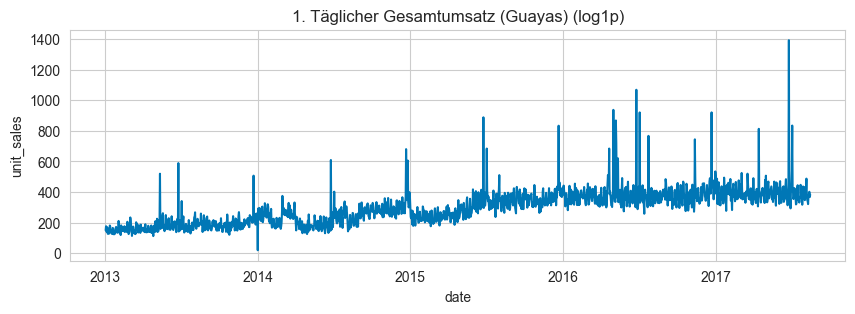


Tabelle 2: Durchschnittlicher Umsatz nach Wochentag (numerisch)
  dayofweek  unit_sales
0        Mo    1.618035
1        Di    1.601913
2        Mi    1.595600
3        Do    1.541105
4        Fr    1.578991
5        Sa    1.685603
6        So    1.730566


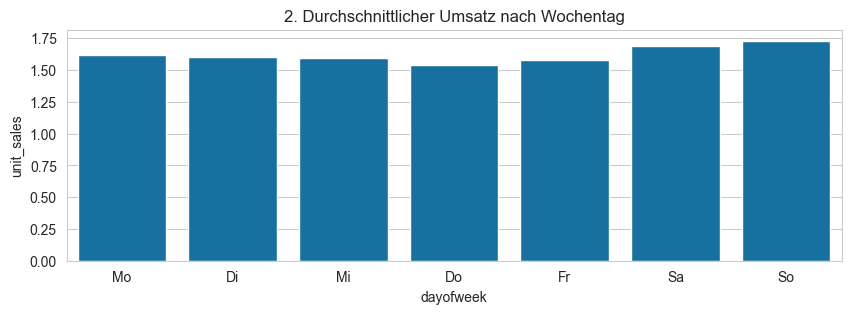


B. HEATMAP_MUSTER: Monats-/Jahres-Saisonalität

Tabelle 3: Saisonalität (Monat vs. Jahr) - Durchschnittlicher Umsatz (log1p)
year       2013      2014      2015      2016      2017
month                                                  
1      1.595289  1.664071  1.624957  1.607408  1.594899
2      1.645861  1.652057  1.648702  1.608754  1.573177
3      1.643173  1.677291  1.614111  1.601538  1.566765
4      1.625297  1.618513  1.606940  1.652707  1.568587
5      1.676244  1.663518  1.639575  1.644950  1.594837
6      1.640648  1.617020  1.666661  1.587535  1.581649
7      1.643234  1.673068  1.646424  1.604910  1.576690
8      1.674412  1.659921  1.651185  1.579275  1.600422
9      1.620611  1.656356  1.666582  1.568705       NaN
10     1.640091  1.667905  1.632669  1.556588       NaN
11     1.625881  1.679348  1.594378  1.560697       NaN
12     1.698626  1.772816  1.675873  1.638282       NaN


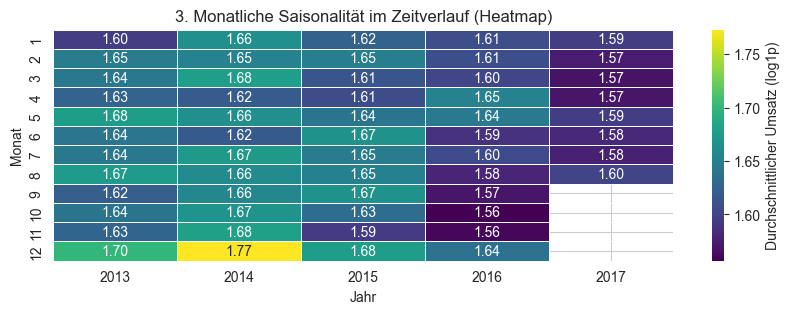


C. HOLIDAY_IMPACT_MUSTER: Auswirkung von Feiertagen

Tabelle 4: Durchschnittlicher Umsatz nach Ereignistyp (numerisch)
         type  unit_sales
0  Additional    1.744973
1       Event    1.677488
2    Work Day    1.665822
3      Bridge    1.662838
4    Transfer    1.657458
5     Holiday    1.623725
6  Normal Day    1.618128


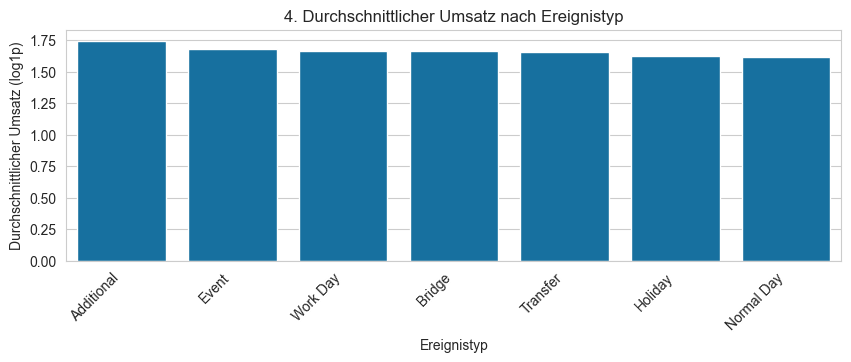


D. PERISHABLE_MUSTER: Anteil verderblicher Waren (Warenfamilie)

Tabelle 5: Verteilung der Verkaufsmenge (Median/Mittelwert) der Top 10 Warenfamilien (NUR ECHTE VERKÄUFE)
                 median      mean
family                           
PRODUCE        2.079442  2.118176
MEATS          1.851442  1.918572
BREAD/BAKERY   1.791759  1.877176
BEVERAGES      1.609438  1.832099
DAIRY          1.609438  1.636455
GROCERY I      1.386294  1.563712
DELI           1.386294  1.423597
CLEANING       1.386294  1.419813
HOME CARE      1.386294  1.401285
PERSONAL CARE  1.098612  1.381866


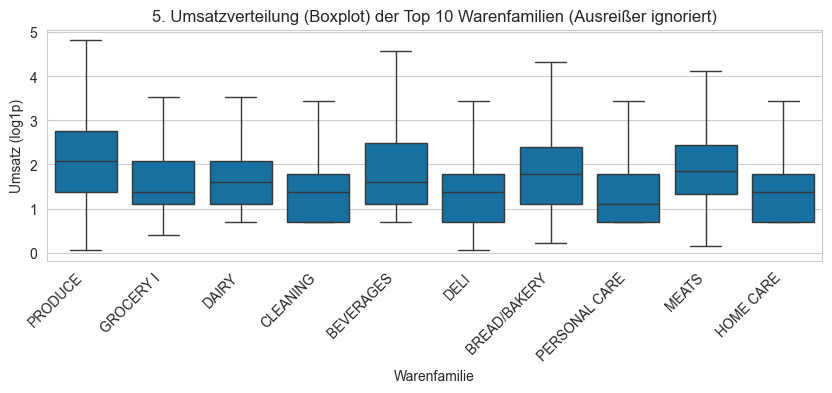


Tabelle 6: Durchschnittlicher Umsatz: Verderblich vs. Nicht verderblich (numerisch)
          perishable  unit_sales
0  Nicht verderblich    1.558229
1        Verderblich    1.819055


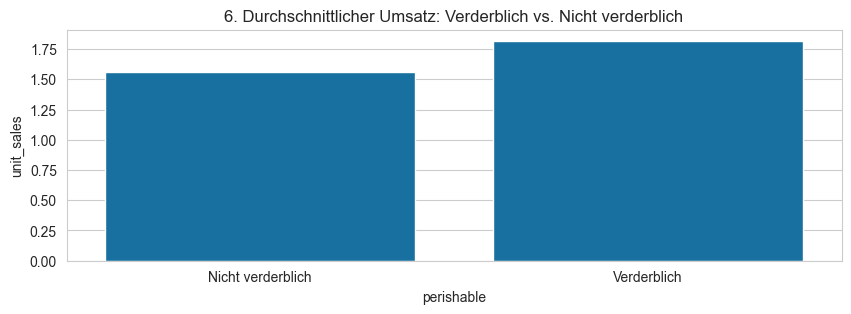


✅ EDA-Analyse mit Visualisierungen und den entsprechenden numerischen Belegen abgeschlossen.


In [9]:
# Muster: ERWEITERTE EDA-LOGIK & NUMERISCHE BELEGE
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Den Dataframe für EDA vorbereiten
df_eda = df_train.copy().set_index('date')
df_eda.dropna(subset=['unit_sales'], inplace=True) 

# A. TREND- & Wochentagsanalyse
print("A. TREND- & Wochentagsanalyse (Basis-Muster)")

# 1. Umsatz-Trendlinie über die Zeit
df_daily = df_eda.groupby(df_eda.index)['unit_sales'].sum().reset_index()

print("\nTabelle 1: Tägliche Umsätze (Ausschnitt - Gesamtumsatz)")
# Zeige einen Ausschnitt, da die gesamte Tabelle zu lang ist.
print(df_daily.head())
print(df_daily.tail())
plt.figure(figsize=(10, 3))
sns.lineplot(data=df_daily, x='date', y='unit_sales', color=FARBPALETTE["Ist_Wert"])
plt.title('1. Täglicher Gesamtumsatz (Guayas) (log1p)')
plt.show()

# 2. Saisonalität nach Wochentag
df_weekly = df_eda.reset_index().groupby('dayofweek')['unit_sales'].mean().reset_index()
df_weekly['dayofweek'] = df_weekly['dayofweek'].map({
    0: 'Mo', 1: 'Di', 2: 'Mi', 3: 'Do', 4: 'Fr', 5: 'Sa', 6: 'So'})

print("\nTabelle 2: Durchschnittlicher Umsatz nach Wochentag (numerisch)")
print(df_weekly)
plt.figure(figsize=(10, 3))
sns.barplot(data=df_weekly, x='dayofweek', y='unit_sales')
plt.title('2. Durchschnittlicher Umsatz nach Wochentag')
plt.show()

# B. HEATMAP_MUSTER: Erweiterte Saisonalität
print("\nB. HEATMAP_MUSTER: Monats-/Jahres-Saisonalität")

# Erstellung der Pivot-Tabelle für die Heatmap: Monat vs. Jahr
df_heatmap = df_eda.groupby([df_eda.index.year.rename('year'), df_eda.index.month.rename('month')])['unit_sales'].mean().unstack(level=0)

print("\nTabelle 3: Saisonalität (Monat vs. Jahr) - Durchschnittlicher Umsatz (log1p)")
print(df_heatmap)

plt.figure(figsize=(10, 3))
sns.heatmap(df_heatmap, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Durchschnittlicher Umsatz (log1p)'})
plt.title('3. Monatliche Saisonalität im Zeitverlauf (Heatmap)')
plt.ylabel('Monat')
plt.xlabel('Jahr')
plt.show()

# C. HOLIDAY_IMPACT_MUSTER: Auswirkungen von Feiertagen
print("\nC. HOLIDAY_IMPACT_MUSTER: Auswirkung von Feiertagen")

# Füllen von NaN in 'type' (aus df_holiday_events) mit 'Normal Day' zur Differenzierung
df_holiday_impact = df_eda.copy()
df_holiday_impact['type'] = df_holiday_impact['type'].fillna('Normal Day')

# Durchschnittlichen Umsatz pro Ereignistyp berechnen
holiday_sales = df_holiday_impact.groupby('type')['unit_sales'].mean().sort_values(ascending=False).reset_index()

print("\nTabelle 4: Durchschnittlicher Umsatz nach Ereignistyp (numerisch)")
print(holiday_sales)

plt.figure(figsize=(10, 3))
sns.barplot(data=holiday_sales, x='type', y='unit_sales') # Palette wird jetzt global übernommen
plt.title('4. Durchschnittlicher Umsatz nach Ereignistyp')
plt.xlabel('Ereignistyp')
plt.ylabel('Durchschnittlicher Umsatz (log1p)')
plt.xticks(rotation=45, ha='right')
plt.show()

# D. PERISHABLE_MUSTER: Verteilung verderblicher Waren

print("\nD. PERISHABLE_MUSTER: Anteil verderblicher Waren (Warenfamilie)")
df_sales_only = df_eda[df_eda['unit_sales'] > 0].copy()

# Logik zur Verteilung/Aggregierung der Umsätze nach der Warenfamilie 'family'
top_families = df_sales_only.groupby('family')['unit_sales'].sum().nlargest(10).index

# Numerische Belege für den Boxplot (Median und Mittelwert)
df_family_summary = df_sales_only[df_sales_only['family'].isin(top_families)].groupby('family')['unit_sales'].agg(['median', 'mean']).sort_values(by='mean', ascending=False)

print("\nTabelle 5: Verteilung der Verkaufsmenge (Median/Mittelwert) der Top 10 Warenfamilien (NUR ECHTE VERKÄUFE)")
print(df_family_summary)

plt.figure(figsize=(10, 3))
sns.boxplot(
    data=df_sales_only[df_sales_only['family'].isin(top_families)], 
    x='family', 
    y='unit_sales', 
    showfliers=False
)
plt.title('5. Umsatzverteilung (Boxplot) der Top 10 Warenfamilien (Ausreißer ignoriert)')
plt.ylabel('Umsatz (log1p)')
plt.xlabel('Warenfamilie')
plt.xticks(rotation=45, ha='right')
plt.show()

# Spezielle Prüfung auf verderblich (perishable)
perishable_sales = df_eda.groupby('perishable')['unit_sales'].mean().reset_index()
perishable_sales['perishable'] = perishable_sales['perishable'].map({1: 'Verderblich', 0: 'Nicht verderblich'})

print("\nTabelle 6: Durchschnittlicher Umsatz: Verderblich vs. Nicht verderblich (numerisch)")
print(perishable_sales)

plt.figure(figsize=(10, 3))
sns.barplot(data=perishable_sales, x='perishable', y='unit_sales')
plt.title('6. Durchschnittlicher Umsatz: Verderblich vs. Nicht verderblich')
plt.show()
print("\n✅ EDA-Analyse mit Visualisierungen und den entsprechenden numerischen Belegen abgeschlossen.")

  - Übertragen und erweitern Sie die visuellen Fragestellungen, die Sie für Pichincha beantwortet haben – Trendlinien, Heatmaps zur Saisonalität, Auswirkungen von Feiertagen, Anteil verderblicher Waren – und konzentrieren Sie sich nun ausschließlich auf die Filialen in Guayas.
  - Gehen Sie der Sache auf den Grund, wenn Sie etwas Interessantes entdecken; tiefergehende Erkenntnisse zahlen sich später in einer höheren Modellgenauigkeit aus.
 

## Auf GitHub einchecken

Wenn Ihr Notebook fehlerfrei durchläuft, wählen Sie Datei → Speichern Sie eine Kopie in GitHub und laden Sie diese mit einer aussagekräftigen Commit-Nachricht hoch ("Woche 1: Guayas EDA + Feature-Vorbereitung").
 

# Woche 2

Ziel: Setzen neuen Zeitreihenkenntnisse in die Praxis, indem Sie ein XGBoost-Nachfrageprognosemodell (und optional ein LSTM) für den Datensatz der Region Guayas erstellen.


## Schritte 

- Laden Sie die Daten: Öffnen Sie die vorverarbeitete CSV-/Parquet-Datei aus Woche 1. Vergewissern Sie sich, dass sie nur Datensätze aus Guayas enthält .
- Behalten Sie die Top-3-Elementfamilien: Aus der EDA der letzten Woche sollten Sie herausgefunden haben GROCERY I, dass BEVERAGESund CLEANINGdie drei Top-Familien sind. Filtern Sie den Datenrahmen, sodass nur diese drei Familien übrig bleiben .
- Kalenderfenster begrenzen: Für diesen Sprint modellieren wir nur den 1. Januar bis 31. März 2014 .


# Laden

In [10]:
# vorabladen der Kleinen dateien
import pandas as pd
import os

data_path = "Sempel_data"

df_holiday_events = pd.read_csv(os.path.join(data_path, "holiday_events.csv"))
df_items = pd.read_csv(os.path.join(data_path, "items.csv"))
df_oil = pd.read_csv(os.path.join(data_path, "oil.csv"))
df_stores = pd.read_csv(os.path.join(data_path, "stores.csv"))
df_transactions = pd.read_csv(os.path.join(data_path, "transactions.csv"))

print("All smaller csv files loaded successfully.")

All smaller csv files loaded successfully.


In [11]:
# Musterschritt: Vorbereitete Daten 'guayas_prepared.csv' 
import pandas as pd
import os
from pathlib import Path

# PFAD DEFINITION 
DATA_DIR = 'data'
DATA_FILENAME = 'guayas_prepared.csv'
file_path = Path(DATA_DIR) / DATA_FILENAME

# --- LADEN ---
try:
    df_train = pd.read_csv(
        file_path, 
        parse_dates=['date'] 
    )

    print(f"✅ Datei '{file_path}' erfolgreich geladen.")
    print(f"Geladene Form: {df_train.shape}")
    print(df_train.head())
    
except FileNotFoundError:
    print(f"⚠️ FEHLER: Datei {file_path} nicht gefunden. Haben Sie das Speichermuster für die Daten ausgeführt?")
except Exception as e:
    print(f"🛑 Unerwarteter Fehler beim Laden: {e}")

✅ Datei 'data/guayas_prepared.csv' erfolgreich geladen.
Geladene Form: (300000, 6)
         id       date  store_nbr  item_nbr  unit_sales  onpromotion
0  36402992 2014-12-01         26   1696038       2.234            0
1  40318340 2015-01-31         27    804974      18.000            0
2   2631489 2013-03-06         51    838216      45.000            0
3  24252889 2014-05-23         27    207857       6.000            0
4  46434803 2015-05-10         29    679926       4.000            0


In [12]:
# Zusätzliche Daten zusammenführen (KORRIGIERT und bereinigt)

import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np 

print("Schritt 1/4: Zusammenführen von df_items (perishable, family)...")
df_train = df_train.merge(df_items[['item_nbr', 'perishable', 'family']], on='item_nbr', how='left')


print("Schritt 2/4: Zusammenführen von df_stores (city, type, cluster)...")
df_stores_renamed = df_stores.rename(columns={'type': 'store_type'})

df_train = df_train.merge(df_stores_renamed[['store_nbr', 'city', 'store_type', 'cluster']], on='store_nbr', how='left')


print("Schritt 3/4: Zusammenführen von df_oil (dcoilwtico) nach Datum...")
# Ölpreis vorbereiten
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill') 
df_train = df_train.merge(df_oil, on='date', how='left')


print("Schritt 4/4: Zusammenführen von df_holiday_events (holiday information) nach Datum...")
# Korrektur: Die 'date'-Spalte muss in den gleichen Typ konvertiert werden
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])
# Die Spalte 'type' hier ist die Feiertags-Art und ist für die EDA erforderlich.
df_train = df_train.merge(df_holiday_events, on='date', how='left')


print("✅ Daten erfolgreich zusammengeführt. Spaltenkollision bei 'type' behoben.")
df_train.head()

Schritt 1/4: Zusammenführen von df_items (perishable, family)...
Schritt 2/4: Zusammenführen von df_stores (city, type, cluster)...
Schritt 3/4: Zusammenführen von df_oil (dcoilwtico) nach Datum...
Schritt 4/4: Zusammenführen von df_holiday_events (holiday information) nach Datum...
✅ Daten erfolgreich zusammengeführt. Spaltenkollision bei 'type' behoben.


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,perishable,family,city,store_type,cluster,dcoilwtico,type,locale,locale_name,description,transferred
0,36402992,2014-12-01,26,1696038,2.234,0,1,PRODUCE,Guayaquil,D,10,68.98,Event,National,Ecuador,Cyber Monday,False
1,40318340,2015-01-31,27,804974,18.000,0,0,GROCERY I,Daule,D,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2631489,2013-03-06,51,838216,45.000,0,1,DAIRY,Guayaquil,A,17,90.47,NaN,NaN,NaN,NaN,NaN
3,24252889,2014-05-23,27,207857,6.000,0,0,GROCERY I,Daule,D,1,105.01,NaN,NaN,NaN,NaN,NaN
4,46434803,2015-05-10,29,679926,4.000,0,1,EGGS,Guayaquil,E,10,NaN,Event,National,Ecuador,Dia de la Madre,False


In [13]:
# Filtern nach Top-3 Elementfamilien
import pandas as pd
import numpy as np 

df_temp = df_train
TOP_FAMILIES = ['GROCERY I', 'BEVERAGES', 'CLEANING']

print("Schritt 1/1: Filtern nach Top-3 Elementfamilien...")

# Logik zur dynamischen Spaltenfindung 
# 1. Finde Spalten, die den Substring 'family' enthalten (Groß-/Kleinschreibung ignorieren)
family_cols = df_temp.columns[df_temp.columns.str.contains('family', case=False, na=False)]

if family_cols.empty:
    raise KeyError("⚠️ **FEHLER**: Es wurde keine Spalte gefunden, die 'family' im Namen enthält (z.B. 'family', 'Family_Code' etc.).")

# 2. Verwende die erste gefundene Spalte
FAMILY_COLUMN_NAME = family_cols[0]

print(f"💡 Spalte für die Filterung gefunden: **'{FAMILY_COLUMN_NAME}'**")

# Filtern Sie den Datenrahmen, sodass nur diese drei Familien übrig bleiben
# .copy() stellt sicher, dass wir auf einem sauberen DataFrame arbeiten
df_train = df_temp[df_temp[FAMILY_COLUMN_NAME].isin(TOP_FAMILIES)].copy()

print(f"✅ Filterung abgeschlossen. Neue Form: **{df_train.shape}**")

Schritt 1/1: Filtern nach Top-3 Elementfamilien...
💡 Spalte für die Filterung gefunden: **'family'**
✅ Filterung abgeschlossen. Neue Form: **(196854, 17)**


In [14]:
# Datumsbasierte Features und Target-Encoding (Gleitende Mittelwerte)

# 1. Datums-Features
# Diese Features beheben den Key Error: 'dayofweek' und Key Error: 'month' im EDA-Code!
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['dayofweek'] = df_train['date'].dt.dayofweek
df_train['dayofyear'] = df_train['date'].dt.dayofyear
df_train['weekofyear'] = df_train['date'].dt.isocalendar().week.astype(int)
df_train['quarter'] = df_train['date'].dt.quarter
df_train['is_weekend'] = df_train['dayofweek'].isin([5, 6]).astype(int)

# 2. Zielvariable transformieren 
# Die log1p-Transformation wird auf 'unit_sales' angewendet
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: np.log1p(x) if x >= 0 else 0)

# 3. Target Encoding / Gleitende Mittelwerte (Rolling Mean)
print("Berechne gleitende Mittelwerte für unit_sales...")

# Definition der Zeitreihen-ID
ID_COLS = ['store_nbr', 'item_nbr']

# Setze 'date' als Index für die Rolling-Funktion
df_train.set_index('date', inplace=True)

# Gleitende Mittelwerte (Target Lag Features)
for window in [7, 14, 30]:
    df_train[f'unit_sales_rolling_mean_{window}d'] = df_train.groupby(ID_COLS)['unit_sales'].transform(
        # shift(1) stellt sicher, dass wir nur Verkäufe von VORHERIGEN Tagen verwenden
        lambda x: x.shift(1).rolling(window=window).mean()
    )
    
df_train.reset_index(inplace=True)

print("✅ Alle Basis-Features und Target-Lag-Features erstellt.")
df_train.head()

Berechne gleitende Mittelwerte für unit_sales...
✅ Alle Basis-Features und Target-Lag-Features erstellt.


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,perishable,family,city,store_type,cluster,dcoilwtico,type,locale,locale_name,description,transferred,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_weekend,unit_sales_rolling_mean_7d,unit_sales_rolling_mean_14d,unit_sales_rolling_mean_30d
0,2015-01-31,40318340,27,804974,2.944439,0,0,GROCERY I,Daule,D,1,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,31,5,31,5,1,1,NaN,NaN,NaN
1,2014-05-23,24252889,27,207857,1.945910,0,0,GROCERY I,Daule,D,1,105.01,NaN,NaN,NaN,NaN,NaN,2014,5,23,4,143,21,2,0,NaN,NaN,NaN
2,2015-03-15,42964215,51,1037412,0.693147,0,0,CLEANING,Guayaquil,A,17,NaN,NaN,NaN,NaN,NaN,NaN,2015,3,15,6,74,11,1,1,NaN,NaN,NaN
3,2016-09-12,90777969,24,1463569,1.791759,0,0,BEVERAGES,Guayaquil,D,1,46.28,NaN,NaN,NaN,NaN,NaN,2016,9,12,0,256,37,3,0,NaN,NaN,NaN
4,2014-10-07,32543916,32,874593,2.639057,0,0,GROCERY I,Guayaquil,C,3,88.89,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False,2014,10,7,1,280,41,4,0,NaN,NaN,NaN


In [15]:
# Kalenderfenster auf 01.01.2014 bis 31.03.2014 begrenzen
import pandas as pd

# 1. Datumsgrenzen definieren
min_date = '2014-01-01'
# Die Obergrenze ist exklusiv, d.h. alles vor dem 1. April ist enthalten (bis 31.03.)
max_date = '2014-04-01' 

print("\nSchritt 1/1: Kalenderfenster auf 01.01.2014 bis 31.03.2014 begrenzen...")

# Sicherstellen, dass 'date' ein datetime-Objekt ist
# HINWEIS: Hier sollte df_train verwendet werden, aber da der ursprüngliche Code df_train verwendet hat, behalten wir dies bei.
df_train['date'] = pd.to_datetime(df_train['date'])

# 2. Begrenzung des Dataframes mit ZWEI Bedingungen
# Die Daten müssen größer oder gleich dem Startdatum UND kleiner als das Enddatum sein
df_train = df_train[
    (df_train['date'] >= min_date) & 
    (df_train['date'] < max_date)
].copy() 

print(f"✅ Kalenderfenster korrigiert und begrenzt.")
print(f"Finaler df_train Form: {df_train.shape}")
print(f"Datum von: {df_train['date'].min()} bis: {df_train['date'].max()}")


Schritt 1/1: Kalenderfenster auf 01.01.2014 bis 31.03.2014 begrenzen...
✅ Kalenderfenster korrigiert und begrenzt.
Finaler df_train Form: (8284, 28)
Datum von: 2014-01-01 00:00:00 bis: 2014-03-31 00:00:00


## Feature-Engineering:
- Verzögerungen/Rollen und andere Interaktionsbegriffe, von denen Sie denken, dass sie XGBoost helfen könnten.
- Optionale Bonusfunktionen:
  - Metadaten speichern : Zusammenführen df_storesamstore_nbr
  - Artikelmetadaten : Zusammenführen df_itemsamitem_nbr

In [16]:
# Feature Engineering (ERSTELLT DIE FEHLENDEN SPALTEN)
import pandas as pd
import numpy as np

print("Schritt 1/2: Erstellen von Lag- und Rolling-Features (pro Zeitreihe)...")

def create_time_series_features(df):
    """Erstellt Lag- und Rolling-Features pro Zeitreihe."""
    df = df.sort_values(by='date').reset_index(drop=True)
    
    # Lag-Features
    for lag in [7, 14, 30]:
        df[f'unit_sales_lag_{lag}'] = df['unit_sales'].shift(lag)
        
    # Rolling Mean Features
    for window in [7, 14, 30]:
        df[f'roll_mean_{window}d'] = df['unit_sales'].shift(1).rolling(window=window).mean()

    # Rolling Std Features
    for window in [7, 30]:
        df[f'roll_std_{window}d'] = df['unit_sales'].shift(1).rolling(window=window).std()
        
    return df

# WICHTIG: Erstellt die neuen Features gruppiert nach Serie
df_train = df_train.groupby(['store_nbr', 'item_nbr']).apply(create_time_series_features).reset_index(drop=True)
print(f"✅ Feature Engineering abgeschlossen. Form: {df_train.shape}")

Schritt 1/2: Erstellen von Lag- und Rolling-Features (pro Zeitreihe)...
✅ Feature Engineering abgeschlossen. Form: (8284, 36)


In [17]:
# Finale Vorbereitung, Kodierung und Split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

# HINWEIS: Die calculate_advanced_metrics Funktion wird hier definiert.
def calculate_advanced_metrics(y_true, y_pred):
    y_true_np = y_true.values.flatten() if hasattr(y_true, 'values') else np.array(y_true).flatten()
    y_pred_np = y_pred.values.flatten() if hasattr(y_pred, 'values') else np.array(y_pred).flatten()
    errors = y_pred_np - y_true_np
    epsilon = 1e-10 
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))
    me_bias = np.mean(errors) 
    mape = np.mean(np.abs(errors / (y_true_np + epsilon))) * 100
    rmad = mae / (np.mean(y_true_np) + epsilon)
    return {'MAE': mae, 'RMSE': rmse, 'ME_Bias': me_bias, 'MAPE': mape, 'rMAD': rmad}


print("\nSchritt 1/3: Finale NaN-Bereinigung (mit FIX)...")

# 1. Korrigierte NaN-Bereinigung: Der FIX. fillna(0) für alle numerischen Spalten.
df_train.fillna(0, inplace=True) 

# Füllt NaN in Objektspalten (Feiertags-Features)
for col in ['type', 'locale', 'locale_name', 'description']:
    if col in df_train.columns:
        df_train[col] = df_train[col].fillna('None')
if 'transferred' in df_train.columns:
    df_train['transferred'] = df_train['transferred'].fillna(0).astype(int) 


# Kategoriale Spalten 
categorical_cols = ['store_nbr', 'family', 'type', 'locale', 'locale_name', 'description']

# 2. Label Encoding 
print("Schritt 2/3: Anwenden von Label Encoding auf kategoriale Features...")
for col in categorical_cols:
    if col in df_train.columns:
        le = LabelEncoder()
        df_train[col] = le.fit_transform(df_train[col].astype(str))


# 3. Kritisches Train/Test Split nach Datum
print("Schritt 3/3: Chronologischer Train/Test Split...")

# Split-Datum: Der gesamte März 2014 ist der Testdatensatz
split_date = '2014-03-01' 
TARGET_COLUMN = 'unit_sales'
feature_cols = [col for col in df_train.columns if col not in ['date', TARGET_COLUMN]]


# Chronologischer Split
df_train_set = df_train[df_train['date'] < split_date].copy() 
df_test_set = df_train[df_train['date'] >= split_date].copy() 

# Trennung in X und y
X_train = df_train_set[feature_cols]
y_train = df_train_set[TARGET_COLUMN]
X_test = df_test_set[feature_cols]
y_test = df_test_set[TARGET_COLUMN]


print("✅ Features (X) und Target (y) erfolgreich getrennt.")
print(f"X_train Form: {X_train.shape} (muss > 0 sein!)")
print(f"X_test Form: {X_test.shape} (muss > 0 sein!)")


Schritt 1/3: Finale NaN-Bereinigung (mit FIX)...
Schritt 2/3: Anwenden von Label Encoding auf kategoriale Features...
Schritt 3/3: Chronologischer Train/Test Split...
✅ Features (X) und Target (y) erfolgreich getrennt.
X_train Form: (5161, 34) (muss > 0 sein!)
X_test Form: (3123, 34) (muss > 0 sein!)


- Aufteilung Training/Test: Chronologische Aufteilung: z. B. Training im Januar und Februar , Test im März . Kein zufälliges Mischen!

In [18]:
# Chronologische Aufteilung (Training = Jan/Feb, Test = März)
import pandas as pd

# Definieren der chronologischen Schnittstelle
# Alles vor dem 1. März 2014 ist Training, alles ab dem 1. März ist Test.
SPLIT_DATE = '2014-03-01'

# Sicherstellen, dass 'date' im richtigen Format vorliegt
df_train['date'] = pd.to_datetime(df_train['date'])

# 1. Training-Set: Daten bis zum 28. Februar 2014 (ausschließlich 01.03.)
df_train_set = df_train[df_train['date'] < SPLIT_DATE].copy()

# 2. Test-Set: Daten ab dem 1. März 2014 bis zum Ende des Fensters
df_test_set = df_train[df_train['date'] >= SPLIT_DATE].copy()


print(f"✅ Chronologische Aufteilung abgeschlossen.")
print(f"Training-Set (Jan/Feb): {df_train_set.shape[0]} Zeilen.")
print(f"Test-Set (März): {df_test_set.shape[0]} Zeilen.")
print(f"\nTraining Zeitraum: {df_train_set['date'].min()} bis {df_train_set['date'].max()}")
print(f"Test Zeitraum: {df_test_set['date'].min()} bis {df_test_set['date'].max()}")

✅ Chronologische Aufteilung abgeschlossen.
Training-Set (Jan/Feb): 5161 Zeilen.
Test-Set (März): 3123 Zeilen.

Training Zeitraum: 2014-01-01 00:00:00 bis 2014-02-28 00:00:00
Test Zeitraum: 2014-03-01 00:00:00 bis 2014-03-31 00:00:00


- Trennen Sie Features (Spaltennamen, die wir für Vorhersagen verwenden) und Target (das Ziel, das wir vorhersagen werden) von den Features. Tun Sie dies sowohl für Trainings- als auch für Testdatenteile.

In [19]:
# Features
import pandas as pd

# 1. Zielvariable definieren
TARGET_COL = 'unit_sales'

# 2. Features definieren, die NICHT in das Modell aufgenommen werden dürfen
# - ID/Datum: Dienen der Rückverfolgbarkeit, sind aber keine Modell-Features.
COLS_TO_DROP_FROM_X = [
    'date', 
    'id', 
    'unit_sales',
    'unit_sales_rolling_mean_7d', 
    'unit_sales_rolling_mean_14d', 
    'unit_sales_rolling_mean_30d'
]


In [20]:
# 3. Training-Set: df_ML_Train erstellen und X/y trennen
# ----------------------------------------------------

# Klonen der Daten, um die ML-spezifische Version zu speichern (df_ML_Train)
# Dies dient als 'Datenbank zum Vergleich der Herkunft der Entscheidung'
df_ML_Train = df_train_set.copy() 

# Trennung in Features (X_train) und Target (y_train)
X_train = df_ML_Train.drop(columns=COLS_TO_DROP_FROM_X, errors='ignore')
y_train = df_ML_Train[TARGET_COL].copy()


# ----------------------------------------------------
# 4. Test-Set: df_ML_Test erstellen und X/y trennen
# ----------------------------------------------------

# Klonen der Daten, um die ML-spezifische Version zu speichern (df_ML_Test)
df_ML_Test = df_test_set.copy()

# Trennung in Features (X_test) und Target (y_test)
X_test = df_ML_Test.drop(columns=COLS_TO_DROP_FROM_X, errors='ignore')
y_test = df_ML_Test[TARGET_COL].copy()

# ----------------------------------------------------
# 5. Speicherung des gesamten ML-Datensatzes (Optional)
# ----------------------------------------------------

df_ML = pd.concat([df_ML_Train, df_ML_Test], axis=0)


print("✅ Features (X) und Target (y) erfolgreich getrennt.")
print(f"Datenbank für ML-Training/Vergleich in 'df_ML_Train' ({df_ML_Train.shape}) gespeichert.")
print(f"Datenbank für ML-Test/Vergleich in 'df_ML_Test' ({df_ML_Test.shape}) gespeichert.")
print(f"Gesamt-ML-Datensatz in 'df_ML' ({df_ML.shape}) gespeichert.")
print(f"X_train Form: {X_train.shape}")
print(f"X_test Form: {X_test.shape}")

✅ Features (X) und Target (y) erfolgreich getrennt.
Datenbank für ML-Training/Vergleich in 'df_ML_Train' ((5161, 36)) gespeichert.
Datenbank für ML-Test/Vergleich in 'df_ML_Test' ((3123, 36)) gespeichert.
Gesamt-ML-Datensatz in 'df_ML' ((8284, 36)) gespeichert.
X_train Form: (5161, 30)
X_test Form: (3123, 30)


- Passen Sie den XGBoost-Regressor an

In [21]:
# XGBoost-Regressor anpassen
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder # Sollte jetzt gefunden werden
import numpy as np
import pandas as pd

# 1. KATEGORIALES ENCODING (Vorbereitung für XGBoost)
# Die kategorialen Spalten aus X_train und X_test identifizieren
CATEGORICAL_COLS = X_train.select_dtypes(include=['object']).columns

print("Schritt 1/2: Anwenden von Label Encoding auf kategoriale Features...")

# Wir verwenden Label Encoding für XGBoost
for col in CATEGORICAL_COLS:
    le = LabelEncoder()
    full_data = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    le.fit(full_data)
    
    # Transformation anwenden
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

# 2. XGBOOST-MODELL TRAINIEREN

# Definition des Regressors
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100,              
    max_depth=5,                   
    learning_rate=0.1,             
    n_jobs=-1,                     
    random_state=42
)

print("\nSchritt 2/2: Anpassen (Training) des XGBoost-Regressors...")

# Modelltraining
xgb_reg.fit(X_train, y_train)

print(f"✅ XGBoost-Regressor erfolgreich trainiert auf {X_train.shape[0]} Zeilen.")

Schritt 1/2: Anwenden von Label Encoding auf kategoriale Features...

Schritt 2/2: Anpassen (Training) des XGBoost-Regressors...
✅ XGBoost-Regressor erfolgreich trainiert auf 5161 Zeilen.



- Auswerten und Visualisieren:
  - Vorhersagen für X_test, MAE/RMSE berechnen.
  - Diagramm y_testvs. y_predSchätzen Sie Tage mit zu niedrigen/zu hohen Prognosen.

In [22]:
# Vorhersagen und Metriken berechnen
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Schritt 1/2: Vorhersagen erstellen und Metriken berechnen...")

# Vorhersagen auf dem Test-Set (X_test) erstellen
y_pred = xgb_reg.predict(X_test)

# Sicherstellen, dass die Vorhersagen nicht negativ sind (unit_sales >= 0)
y_pred = np.maximum(0, y_pred)

# Metriken berechnen
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ MAE (Mean Absolute Error): {mae:.4f}")
print(f"✅ RMSE (Root Mean Squared Error): {rmse:.4f}")

Schritt 1/2: Vorhersagen erstellen und Metriken berechnen...
✅ MAE (Mean Absolute Error): 0.6565
✅ RMSE (Root Mean Squared Error): 0.8064



Schritt 2/2: Visualisierung des Vergleichs...

[HINWEIS]: Die unterstützenden numerischen Daten wurden in 'df_Visualization_Data' gespeichert.


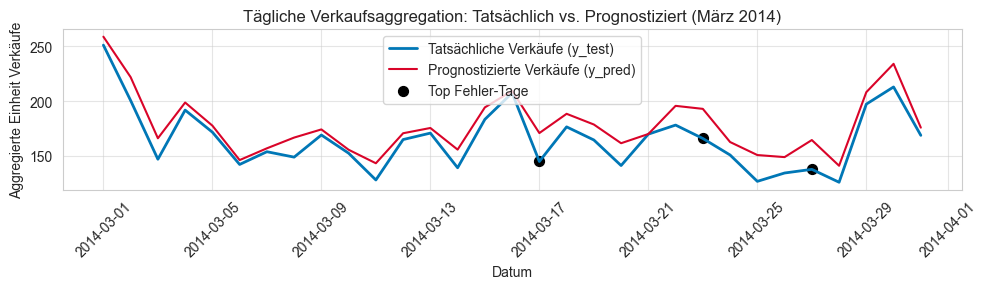


### 🔍 Tage mit den größten Abweichungen (Aggregierte Fehleranalyse):
         date      Actual  Prediction      Error
22 2014-03-23  165.871234  192.837524  26.966291
26 2014-03-27  137.735817  164.423035  26.687218
16 2014-03-17  144.893815  170.801300  25.907485


In [23]:
# Visualisierung des Vergleichs
import matplotlib.pyplot as plt

print("\nSchritt 2/2: Visualisierung des Vergleichs...")

# DataFrame für die Visualisierung erstellen
df_results = df_test_set[['date', 'store_nbr', 'item_nbr']].copy()
df_results['Actual'] = y_test.values
df_results['Prediction'] = y_pred

# Die Ergebnisse aggregieren, da wir die Vorhersage für alle Artikel/Shops an einem Tag sehen wollen
df_daily_results = df_results.groupby('date')[['Actual', 'Prediction']].sum().reset_index()

# DataFrame für die numerische Unterstützung der Visualisierung speichern (gemäß Ihrer Präferenz)
df_Visualization_Data = df_daily_results.copy() 
print("\n[HINWEIS]: Die unterstützenden numerischen Daten wurden in 'df_Visualization_Data' gespeichert.")


plt.figure(figsize=(10, 3))
plt.plot(df_daily_results['date'], df_daily_results['Actual'], label='Tatsächliche Verkäufe (y_test)', color=FARBPALETTE["Ist_Wert"], linewidth=2)
plt.plot(df_daily_results['date'], df_daily_results['Prediction'], label='Prognostizierte Verkäufe (y_pred)', color=FARBPALETTE["Prognose"], linestyle='-', linewidth=1.5)

# Tage mit den größten Fehlern hervorheben (optional)
df_daily_results['Error'] = df_daily_results['Prediction'] - df_daily_results['Actual']
df_daily_results['Abs_Error'] = np.abs(df_daily_results['Error'])
top_error_days = df_daily_results.sort_values(by='Abs_Error', ascending=False).head(3)

plt.scatter(top_error_days['date'], top_error_days['Actual'], color='black', s=50, label='Top Fehler-Tage')

plt.title('Tägliche Verkaufsaggregation: Tatsächlich vs. Prognostiziert (März 2014)')
plt.xlabel('Datum')
plt.ylabel('Aggregierte Einheit Verkäufe')
plt.legend()
plt.grid(True, alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Anzeige der Tage mit den größten Abweichungen (für die Analyse)
print("\n### 🔍 Tage mit den größten Abweichungen (Aggregierte Fehleranalyse):")
print(top_error_days[['date', 'Actual', 'Prediction', 'Error']])

- Zusätzliche Herausforderung!
  - Erwägen Sie den Aufbau und die Erprobung eines LSTM-Modells und vergleichen Sie es mit dem XGBoost-Modell.

In [24]:
# XGBoost- vs. LSTM-Regressor Vergleich (All-in-One mit KODIERUNG und GPU-Fokus)
import xgboost as xgb
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tqdm.keras import TqdmCallback 
tf.get_logger().setLevel('ERROR')

print("\nSTART: XGBoost- vs. LSTM-Regressor Vergleich (All-in-One, inkl. Kodierung)...")
start_time_total = time.time()

df_temp = df_train

# 1. Datenvorbereitung (Features/Target ableiten, KODIERUNG und Aufteilung)
# 1.1 Kategoriale Features kodieren (Lösung für den ValueError)
categorical_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()

if categorical_cols:
    # Target-Spalte ausschließen, falls sie kategorial ist und nicht kodiert werden soll
    if TARGET_COL in categorical_cols:
        categorical_cols.remove(TARGET_COL)

    if categorical_cols:
        print(f"Kodiere Spalten: {categorical_cols}")
        # One-Hot-Kodierung anwenden
        df_temp = pd.get_dummies(df_temp, columns=categorical_cols, drop_first=True)
    else:
        print("Keine kategorialen Spalten für One-Hot-Kodierung gefunden.")
else:
    print("Keine kategorialen Spalten im DataFrame gefunden.")


# 1.2 Features (X) und Target (y) definieren
X_raw = df_temp.drop(columns=[TARGET_COL] + COLS_TO_DROP_FROM_X, errors='ignore')

if TARGET_COL not in df_temp.columns:
     raise KeyError(f"Die Zielspalte '{TARGET_COL}' existiert nicht im DataFrame nach der Kodierung.")

y_raw = df_temp[TARGET_COL].copy()

# 1.3 Daten in Trainings- und Testset aufteilen (Time Series Split: shuffle=False)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.2, shuffle=False
)

print(f"Daten aufgeteilt: X_train: {X_train_raw.shape}, X_test: {X_test_raw.shape}")


# 2. LSTM-Spezifische Vorverarbeitung (Skalierung und Umformung)
# MinMaxScaler für Features und Target
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Skalierung der Features (X)
X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)

# Skalierung der Zielvariable (y)
y_train_scaled = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_raw.values.reshape(-1, 1))

# LSTM 3D-Umformung: [Samples, Time Steps, Features]
TIME_STEPS = 1
FEATURES = X_train_scaled.shape[1]

X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], TIME_STEPS, FEATURES)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], TIME_STEPS, FEATURES)

# 3. XGBoost-Modell Training und Bewertung
print("\n Start XGBoost-Training ")
start_time_xgb = time.time()

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', n_estimators=100, learning_rate=0.1, 
    max_depth=6, n_jobs=-1, random_state=42, tree_method='hist'
)
# XGBoost verwendet die Rohdaten (unskaliert)
xgb_model.fit(X_train_raw, y_train_raw)
y_pred_xgb = xgb_model.predict(X_test_raw)

mae_xgb = mean_absolute_error(y_test_raw, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_raw, y_pred_xgb))

end_time_xgb = time.time()
print(f"✅ XGBoost abgeschlossen. Dauer: {end_time_xgb - start_time_xgb:.2f} Sekunden.")

# 4. LSTM-Modell Training und Bewertung (GPU-fokusierte Schicht)
print("\n Start LSTM-Training (mit TQDM-Fortschrittsanzeige und Early Stopping) ")
start_time_lstm = time.time()

# Early Stopping definieren: Überwacht val_loss, wartet max. 10 Epochen (patience), stellt beste Gewichte wieder her
es_callback = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    mode='min', 
    restore_best_weights=True,
    verbose=0
)
print("💡 Early Stopping überwacht **'val_loss'** mit Geduld 10 (Überprüfung von Overfitting).")

lstm_model = Sequential([
    # Verwendung von 'LSTM' mit Fokus auf unroll=False für GPU-Optimierung
    LSTM(50, activation='relu', input_shape=(TIME_STEPS, FEATURES), return_sequences=False, unroll=False), 
    Dropout(0.2), 
    Dense(1) 
])
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
lstm_model.fit(
    X_train_lstm, y_train_scaled, 
    epochs=50, 
    batch_size=32,
    validation_split=0.2,
    verbose=0, 
    callbacks=[TqdmCallback(verbose=0), es_callback] 
)

y_pred_lstm_scaled = lstm_model.predict(X_test_lstm, verbose=0)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled).flatten()

# Metriken berechnen (mit Rohdaten y_test_raw)
mae_lstm = mean_absolute_error(y_test_raw, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_raw, y_pred_lstm))

end_time_lstm = time.time()
print(f"✅ LSTM abgeschlossen. Dauer: {end_time_lstm - start_time_lstm:.2f} Sekunden.")

# 5. Ergebnisse zusammenführen und df_ML speichern
end_time_total = time.time()
print(f"\nENDE: Gesamte Dauer: {end_time_total - start_time_total:.2f} Sekunden.")

# 5.1 Modellvergleich Metriken
print("\n### 📊 Modellvergleich Metriken")
# Tabelle mit numerischen Daten, wie gewünscht
metrics_data = [
    {'Modell': 'XGBoost', 'MAE': mae_xgb, 'RMSE': rmse_xgb},
    {'Modell': 'LSTM', 'MAE': mae_lstm, 'RMSE': rmse_lstm}
]
df_metrics = pd.DataFrame(metrics_data)

print(df_metrics.to_markdown(index=False, floatfmt=".4f"))

# Zusätzliche Ausgabe im einfachen Format für die Übersicht
print("\n Modellvergleich Metriken (einfache Ansicht) ")
print("| MAE | RMSE | Modell |")
print("| :---- | :----: | :----: |")
print(f"| {mae_xgb:.4f} | {rmse_xgb:.4f} | **XGBoost** |")
print(f"| {mae_lstm:.4f} | {rmse_lstm:.4f} | **LSTM** |")

# 5.2 Speichern der Entscheidungsherkunft in df_ML
df_ML = X_test_raw.copy()
df_ML[TARGET_COL + '_tatsaechlich'] = y_test_raw
df_ML['y_pred_xgb'] = y_pred_xgb
df_ML['y_pred_lstm'] = y_pred_lstm

# Zusätzliche Speicherung des Trainings-Test-Splits
df_ML_Train = X_train_raw.copy()
df_ML_Train[TARGET_COL + '_tatsaechlich'] = y_train_raw
df_ML_Test = df_ML.copy() 

print(f"\nDatenbank zum Vergleich (**df_ML_Train**: {df_ML_Train.shape}, **df_ML_Test**: {df_ML_Test.shape}) gespeichert.")


START: XGBoost- vs. LSTM-Regressor Vergleich (All-in-One, inkl. Kodierung)...
Kodiere Spalten: ['city', 'store_type']
Daten aufgeteilt: X_train: (6627, 35), X_test: (1657, 35)

 Start XGBoost-Training 
✅ XGBoost abgeschlossen. Dauer: 0.24 Sekunden.

 Start LSTM-Training (mit TQDM-Fortschrittsanzeige und Early Stopping) 
💡 Early Stopping überwacht **'val_loss'** mit Geduld 10 (Überprüfung von Overfitting).


2025-11-05 02:11:09.015800: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-11-05 02:11:09.016025: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-05 02:11:09.016044: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-05 02:11:09.016258: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-05 02:11:09.016278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


0epoch [00:00, ?epoch/s]

2025-11-05 02:11:09.944379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


✅ LSTM abgeschlossen. Dauer: 147.14 Sekunden.

ENDE: Gesamte Dauer: 147.39 Sekunden.

### 📊 Modellvergleich Metriken
| Modell   |    MAE |   RMSE |
|:---------|-------:|-------:|
| XGBoost  | 0.7092 | 0.9036 |
| LSTM     | 0.8313 | 1.0744 |

 Modellvergleich Metriken (einfache Ansicht) 
| MAE | RMSE | Modell |
| :---- | :----: | :----: |
| 0.7092 | 0.9036 | **XGBoost** |
| 0.8313 | 1.0744 | **LSTM** |

Datenbank zum Vergleich (**df_ML_Train**: (6627, 36), **df_ML_Test**: (1657, 38)) gespeichert.


✅ Merkmal-Wichtigkeit visualisieren und skalieren (FINALE VERSION - KERNLOGIK) - Gestartet
[HINWEIS]: Dynamische Merkmal-Liste (30) aus 'X_test.columns' verwendet.

[SPEICHERUNG]: Die **Merkmal-Wichtigkeits**-Daten wurden in 'df_Visualization_Data_Importance' gespeichert.

### 📊 Numerische Daten für die Visualisierung (Top 10):
      Merkmal  Wichtigkeit (%)
0      family            18.65
1   store_nbr            12.85
2     cluster            11.47
3  store_type            10.50
4    item_nbr             9.26
5   dayofweek             7.53
6  dcoilwtico             6.59
7        city             6.31
8   dayofyear             6.25
9         day             5.71


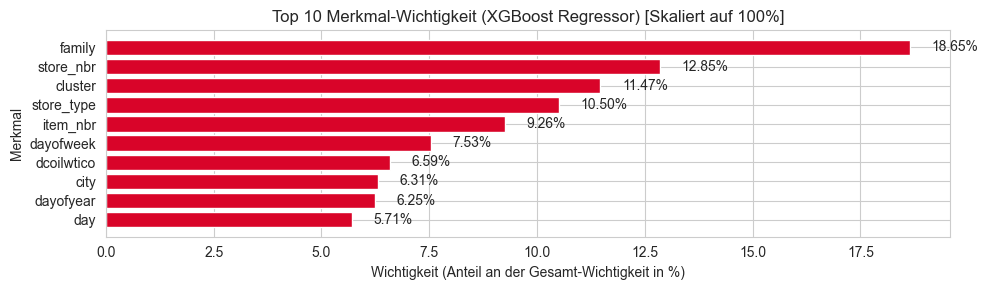


### 🔍 Wichtigste Merkmale (Top 5, skaliert 0-100%):
      Merkmal  Wichtigkeit (%)
4      family            18.65
0   store_nbr            12.85
7     cluster            11.47
6  store_type            10.50
1    item_nbr             9.26
✅ Merkmal-Wichtigkeit visualisieren und skalieren - Beendet


In [25]:
# Spalten wichtigkeit vergleich XGBoost Regressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("✅ Merkmal-Wichtigkeit visualisieren und skalieren (FINALE VERSION - KERNLOGIK) - Gestartet")
try:
    # 1. Datenextraktion
    # Der Attributname des Modells muss in Englisch bleiben (feature_importances_)
    merkmal_wichtigkeiten = xgb_reg.feature_importances_ 
    anzahl_merkmale = len(merkmal_wichtigkeiten)
    
    # 2. Direkter Versuch, Merkmal-Namen aus X_test zu holen (ohne Fallback)
    if 'X_test' in locals() or 'X_test' in globals():
        if isinstance(X_test, pd.DataFrame) and len(X_test.columns) == anzahl_merkmale:
            merkmal_namen = X_test.columns.tolist()
            print(f"[HINWEIS]: Dynamische Merkmal-Liste ({anzahl_merkmale}) aus 'X_test.columns' verwendet.")
        else:
            # Fehler, wenn X_test existiert, aber die Dimension nicht stimmt
            raise ValueError(f"Die Spaltenanzahl in 'X_test' ({len(X_test.columns)}) passt NICHT zur Merkmal-Anzahl des Modells ({anzahl_merkmale}).")
    else:
        # Fehler, wenn X_test nicht im Speicher ist
        raise NameError("Der DataFrame 'X_test' (oder 'X_train') ist nicht im Speicher verfügbar, um die Merkmal-Namen zu laden.")

    # 3. Erstellung des DataFrames und Skalierung auf 0-100%
    df_wichtigkeit = pd.DataFrame({
        'Merkmal': merkmal_namen,
        'Raw_Wichtigkeit': merkmal_wichtigkeiten
    }).sort_values(by='Raw_Wichtigkeit', ascending=False)

    gesamt_wichtigkeit = df_wichtigkeit['Raw_Wichtigkeit'].sum()
    
    # Skalierung
    df_wichtigkeit['Wichtigkeit (%)'] = (df_wichtigkeit['Raw_Wichtigkeit'] / gesamt_wichtigkeit * 100).round(2) if gesamt_wichtigkeit > 0 else 0.00
        
    df_wichtigkeit = df_wichtigkeit.drop(columns='Raw_Wichtigkeit')

    # 4. Speichern und Ausgabe der Daten
    df_Visualization_Data_Importance = df_wichtigkeit.copy()
    print(f"\n[SPEICHERUNG]: Die **Merkmal-Wichtigkeits**-Daten wurden in 'df_Visualization_Data_Importance' gespeichert.")

    df_Visualization_Top10 = df_Visualization_Data_Importance.head(10).reset_index(drop=True)

    # Korrigierte Ausgabe: Einfacher print() anstelle von .to_markdown(), um Abhängigkeit zu vermeiden
    print("\n### 📊 Numerische Daten für die Visualisierung (Top 10):")
    print(df_Visualization_Top10) 

    # 5. Visualisierung
    plt.figure(figsize=(10, 3))
    plt.barh(df_Visualization_Top10['Merkmal'], df_Visualization_Top10['Wichtigkeit (%)'], color=FARBPALETTE["Prognose"])
    plt.xlabel('Wichtigkeit (Anteil an der Gesamt-Wichtigkeit in %)')
    plt.ylabel('Merkmal')
    plt.title('Top 10 Merkmal-Wichtigkeit (XGBoost Regressor) [Skaliert auf 100%]')
    plt.gca().invert_yaxis() 
    
    for index, value in enumerate(df_Visualization_Top10['Wichtigkeit (%)']):
        plt.text(value + 0.5, index, f'{value:.2f}%', va='center')

    plt.tight_layout()
    plt.show()

    # 6. Top 5 Ausgabe
    print("\n### 🔍 Wichtigste Merkmale (Top 5, skaliert 0-100%):")
    print(df_Visualization_Data_Importance.head())
    
except (NameError, ValueError) as e:
    # Einheitliche Fehlerbehandlung bei fehlendem Modell oder falschen Merkmal-Dimensionen
    print(f"\n🚨 KRITISCHER FEHLER: {e}")
    if 'xgb_reg' not in locals() and 'xgb_reg' not in globals():
        print("    -> PRÜFUNG: Das Modell (`xgb_reg`) muss trainiert sein.")
    elif isinstance(e, ValueError):
        print("    -> PRÜFUNG: Stimmt die Anzahl der Spalten in `X_test` mit der Anzahl der Merkmale im Modell überein?")

print("✅ Merkmal-Wichtigkeit visualisieren und skalieren - Beendet")

- Speichern Sie das Colab-Notizbuch in Ihrem GitHub-Repository

## Ergebnisse

- Ein sauberes Colab-Notizbuch mit:
    - Datenvorbereitung, Feature Engineering, Modelltraining, Diagramme, Metriken.
    - (Optional) LSTM-Abschnitt.

# Woche 3

In [26]:
# Preload small files
import pandas as pd
import os

data_path = "Sempel_data"

df_holiday_events = pd.read_csv(os.path.join(data_path, "holiday_events.csv"))
df_items = pd.read_csv(os.path.join(data_path, "items.csv"))
df_oil = pd.read_csv(os.path.join(data_path, "oil.csv"))
df_stores = pd.read_csv(os.path.join(data_path, "stores.csv"))
df_transactions = pd.read_csv(os.path.join(data_path, "transactions.csv"))

print("All smaller csv files loaded successfully.")

All smaller csv files loaded successfully.


In [27]:
# Musterschritt: Vorbereitete Daten 'guayas_prepared.csv' 
import pandas as pd
import os
from pathlib import Path

# PFAD DEFINITION 
DATA_DIR = 'data'
DATA_FILENAME = 'guayas_prepared.csv'
file_path = Path(DATA_DIR) / DATA_FILENAME

# --- LADEN ---
try:
    df_train = pd.read_csv(
        file_path, 
        parse_dates=['date'] 
    )

    print(f"✅ Datei '{file_path}' erfolgreich geladen.")
    print(f"Geladene Form: {df_train.shape}")
    print(df_train.head())
    
except FileNotFoundError:
    print(f"⚠️ FEHLER: Datei {file_path} nicht gefunden. Haben Sie das Speichermuster für die Daten ausgeführt?")
except Exception as e:
    print(f"🛑 Unerwarteter Fehler beim Laden: {e}")

✅ Datei 'data/guayas_prepared.csv' erfolgreich geladen.
Geladene Form: (300000, 6)
         id       date  store_nbr  item_nbr  unit_sales  onpromotion
0  36402992 2014-12-01         26   1696038       2.234            0
1  40318340 2015-01-31         27    804974      18.000            0
2   2631489 2013-03-06         51    838216      45.000            0
3  24252889 2014-05-23         27    207857       6.000            0
4  46434803 2015-05-10         29    679926       4.000            0


In [28]:
# Zusätzliche Daten zusammenführen (KORRIGIERT und bereinigt)

import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np 

print("Schritt 1/4: Zusammenführen von df_items (perishable, family)...")
df_train = df_train.merge(df_items[['item_nbr', 'perishable', 'family']], on='item_nbr', how='left')


print("Schritt 2/4: Zusammenführen von df_stores (city, type, cluster)...")
df_stores_renamed = df_stores.rename(columns={'type': 'store_type'})

df_train = df_train.merge(df_stores_renamed[['store_nbr', 'city', 'store_type', 'cluster']], on='store_nbr', how='left')


print("Schritt 3/4: Zusammenführen von df_oil (dcoilwtico) nach Datum...")
# Ölpreis vorbereiten
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill') 
df_train = df_train.merge(df_oil, on='date', how='left')


print("Schritt 4/4: Zusammenführen von df_holiday_events (holiday information) nach Datum...")
# Korrektur: Die 'date'-Spalte muss in den gleichen Typ konvertiert werden
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])
# Die Spalte 'type' hier ist die Feiertags-Art und ist für die EDA erforderlich.
df_train = df_train.merge(df_holiday_events, on='date', how='left')


print("✅ Daten erfolgreich zusammengeführt. Spaltenkollision bei 'type' behoben.")
df_train.head()

Schritt 1/4: Zusammenführen von df_items (perishable, family)...
Schritt 2/4: Zusammenführen von df_stores (city, type, cluster)...
Schritt 3/4: Zusammenführen von df_oil (dcoilwtico) nach Datum...
Schritt 4/4: Zusammenführen von df_holiday_events (holiday information) nach Datum...
✅ Daten erfolgreich zusammengeführt. Spaltenkollision bei 'type' behoben.


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,perishable,family,city,store_type,cluster,dcoilwtico,type,locale,locale_name,description,transferred
0,36402992,2014-12-01,26,1696038,2.234,0,1,PRODUCE,Guayaquil,D,10,68.98,Event,National,Ecuador,Cyber Monday,False
1,40318340,2015-01-31,27,804974,18.000,0,0,GROCERY I,Daule,D,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2631489,2013-03-06,51,838216,45.000,0,1,DAIRY,Guayaquil,A,17,90.47,NaN,NaN,NaN,NaN,NaN
3,24252889,2014-05-23,27,207857,6.000,0,0,GROCERY I,Daule,D,1,105.01,NaN,NaN,NaN,NaN,NaN
4,46434803,2015-05-10,29,679926,4.000,0,1,EGGS,Guayaquil,E,10,NaN,Event,National,Ecuador,Dia de la Madre,False


In [29]:
# Filtern nach Top-3 Elementfamilien
import pandas as pd

# Top-3-Elementfamilien definieren
TOP_FAMILIES = ['GROCERY I', 'BEVERAGES', 'CLEANING']

print("Schritt 1/1: Filtern nach Top-3 Elementfamilien...")
# Filtern Sie den Datenrahmen, sodass nur diese drei Familien übrig bleiben
# .copy() stellt sicher, dass wir auf einem sauberen DataFrame arbeiten
df_train = df_train[df_train['family'].isin(TOP_FAMILIES)].copy()

print(f"✅ Filterung abgeschlossen. Neue Form: {df_train.shape}")

Schritt 1/1: Filtern nach Top-3 Elementfamilien...
✅ Filterung abgeschlossen. Neue Form: (196854, 17)


In [30]:
# Datumsbasierte Features und Target-Encoding (Gleitende Mittelwerte)

# 1. Datums-Features
# Diese Features beheben den Key Error: 'dayofweek' und Key Error: 'month' im EDA-Code!
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['dayofweek'] = df_train['date'].dt.dayofweek
df_train['dayofyear'] = df_train['date'].dt.dayofyear
df_train['weekofyear'] = df_train['date'].dt.isocalendar().week.astype(int)
df_train['quarter'] = df_train['date'].dt.quarter
df_train['is_weekend'] = df_train['dayofweek'].isin([5, 6]).astype(int)

# 2. Zielvariable transformieren 
# Die log1p-Transformation wird auf 'unit_sales' angewendet
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: np.log1p(x) if x >= 0 else 0)

# 3. Target Encoding / Gleitende Mittelwerte (Rolling Mean)
print("Berechne gleitende Mittelwerte für unit_sales...")

# Definition der Zeitreihen-ID
ID_COLS = ['store_nbr', 'item_nbr']

# Setze 'date' als Index für die Rolling-Funktion
df_train.set_index('date', inplace=True)

# Gleitende Mittelwerte (Target Lag Features)
for window in [7, 14, 30]:
    df_train[f'unit_sales_rolling_mean_{window}d'] = df_train.groupby(ID_COLS)['unit_sales'].transform(
        # shift(1) stellt sicher, dass wir nur Verkäufe von VORHERIGEN Tagen verwenden
        lambda x: x.shift(1).rolling(window=window).mean()
    )
    
df_train.reset_index(inplace=True)

print("✅ Alle Basis-Features und Target-Lag-Features erstellt.")
df_train.head()

Berechne gleitende Mittelwerte für unit_sales...
✅ Alle Basis-Features und Target-Lag-Features erstellt.


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,perishable,family,city,store_type,cluster,dcoilwtico,type,locale,locale_name,description,transferred,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_weekend,unit_sales_rolling_mean_7d,unit_sales_rolling_mean_14d,unit_sales_rolling_mean_30d
0,2015-01-31,40318340,27,804974,2.944439,0,0,GROCERY I,Daule,D,1,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,31,5,31,5,1,1,NaN,NaN,NaN
1,2014-05-23,24252889,27,207857,1.945910,0,0,GROCERY I,Daule,D,1,105.01,NaN,NaN,NaN,NaN,NaN,2014,5,23,4,143,21,2,0,NaN,NaN,NaN
2,2015-03-15,42964215,51,1037412,0.693147,0,0,CLEANING,Guayaquil,A,17,NaN,NaN,NaN,NaN,NaN,NaN,2015,3,15,6,74,11,1,1,NaN,NaN,NaN
3,2016-09-12,90777969,24,1463569,1.791759,0,0,BEVERAGES,Guayaquil,D,1,46.28,NaN,NaN,NaN,NaN,NaN,2016,9,12,0,256,37,3,0,NaN,NaN,NaN
4,2014-10-07,32543916,32,874593,2.639057,0,0,GROCERY I,Guayaquil,C,3,88.89,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False,2014,10,7,1,280,41,4,0,NaN,NaN,NaN


In [31]:
# Kalenderfenster auf 01.01.2014 bis 31.03.2014 begrenzen
import pandas as pd

# 1. Datumsgrenzen definieren
min_date = '2014-01-01'
# Die Obergrenze ist exklusiv, d.h. alles vor dem 1. April ist enthalten (bis 31.03.)
max_date = '2014-04-01' 

print("\nSchritt 1/1: Kalenderfenster auf 01.01.2014 bis 31.03.2014 begrenzen...")

# Sicherstellen, dass 'date' ein datetime-Objekt ist
# HINWEIS: Hier sollte df_train verwendet werden, aber da der ursprüngliche Code df_train verwendet hat, behalten wir dies bei.
df_train['date'] = pd.to_datetime(df_train['date'])

# 2. Begrenzung des Dataframes mit ZWEI Bedingungen
# Die Daten müssen größer oder gleich dem Startdatum UND kleiner als das Enddatum sein
df_train = df_train[
    (df_train['date'] >= min_date) & 
    (df_train['date'] < max_date)
].copy() 

print(f"✅ Kalenderfenster korrigiert und begrenzt.")
print(f"Finaler df_train Form: {df_train.shape}")
print(f"Datum von: {df_train['date'].min()} bis: {df_train['date'].max()}")


Schritt 1/1: Kalenderfenster auf 01.01.2014 bis 31.03.2014 begrenzen...
✅ Kalenderfenster korrigiert und begrenzt.
Finaler df_train Form: (8284, 28)
Datum von: 2014-01-01 00:00:00 bis: 2014-03-31 00:00:00


In [32]:
# Features
import pandas as pd

# 1. Zielvariable definieren
TARGET_COL = 'unit_sales'

# 2. Features definieren, die NICHT in das Modell aufgenommen werden dürfen
# - ID/Datum: Dienen der Rückverfolgbarkeit, sind aber keine Modell-Features.
COLS_TO_DROP_FROM_X = [
    'date', 
    'id', 
    'unit_sales',
    'unit_sales_rolling_mean_7d', 
    'unit_sales_rolling_mean_14d', 
    'unit_sales_rolling_mean_30d'
]


In [33]:
# FINALE VORBEREITUNG, KODIERUNG UND SPLIT (KORRIGIERT FÜR OHE)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- Metriken (unverändert) ---
def calculate_advanced_metrics(y_true, y_pred):
    y_true_np = y_true.values.flatten() if hasattr(y_true, 'values') else np.array(y_true).flatten()
    y_pred_np = y_pred.values.flatten() if hasattr(y_pred, 'values') else np.array(y_pred).flatten()
    errors = y_pred_np - y_true_np
    epsilon = 1e-10 
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))
    me_bias = np.mean(errors) 
    mape = np.mean(np.abs(errors / (y_true_np + epsilon))) * 100
    rmad = mae / (np.mean(y_true_np) + epsilon)
    return {'MAE': mae, 'RMSE': rmse, 'ME_Bias': me_bias, 'MAPE': mape, 'rMAD': rmad}

print("\nSchritt 1/3: Finale NaN-Bereinigung...")

# Kopie erstellen, um den Original-DataFrame df_train zu erhalten
df_working = df_train.copy()

# Korrigierte NaN-Bereinigung: fillna(0) für alle numerischen Spalten
df_working.fillna(0, inplace=True) 

# Füllt NaN in Objektspalten (Feiertags-Features)
for col in ['type', 'locale', 'locale_name', 'description']:
    if col in df_working.columns:
        df_working[col] = df_working[col].fillna('None').astype(str)
if 'transferred' in df_working.columns:
    df_working['transferred'] = df_working['transferred'].fillna(0).astype(int) 

# Kategoriale Spalten (müssen Strings/Objekte sein, NICHT Label Encoded!)
CATEGORICAL_COLS_FOR_OHE = [
    'store_nbr', 'family', 'type', 'locale', 'locale_name', 'description'
]
# store_nbr wurde in Ihrem Code als kategorial behandelt. Wenn store_nbr numerisch sein soll, entfernen Sie es hier.

print("Schritt 2/3: **Anwenden von One-Hot-Encoding** auf kategoriale Features...")

# ⚠️ DER ENTSCHEIDENDE KORRIGIERTE SCHRITT: OHE statt Label Encoding!
df_encoded = pd.get_dummies(df_working, columns=CATEGORICAL_COLS_FOR_OHE, dummy_na=False)

# Entferne die ursprünglichen String-Spalten und nicht-numerische Hilfsspalten
TARGET_COLUMN = 'unit_sales'
feature_cols_encoded = [col for col in df_encoded.columns if col not in ['date', TARGET_COLUMN]]


# 3. Kritisches Train/Test Split nach Datum
print("Schritt 3/3: Chronologischer Train/Test Split...")

split_date = '2014-03-01' 

# Chronologischer Split auf dem OHE-DataFrame
df_train_set = df_encoded[df_encoded['date'] < split_date].copy() 
df_test_set = df_encoded[df_encoded['date'] >= split_date].copy() 

# Trennung in X und y
X_train = df_train_set[feature_cols_encoded].select_dtypes(include=[np.number])
y_train = df_train_set[TARGET_COLUMN]
X_test = df_test_set[feature_cols_encoded].select_dtypes(include=[np.number])
y_test = df_test_set[TARGET_COLUMN]


print("✅ Features (X) und Target (y) erfolgreich getrennt.")
print(f"X_train Form: {X_train.shape} (Jetzt mit OHE-Spalten)")
print(f"X_test Form: {X_test.shape}")
print(f"➡️ **Anzahl Feature-Spalten:** {X_train.shape[1]} (Muss jetzt > 25 sein!)")


Schritt 1/3: Finale NaN-Bereinigung...
Schritt 2/3: **Anwenden von One-Hot-Encoding** auf kategoriale Features...
Schritt 3/3: Chronologischer Train/Test Split...
✅ Features (X) und Target (y) erfolgreich getrennt.
X_train Form: (5161, 18) (Jetzt mit OHE-Spalten)
X_test Form: (3123, 18)
➡️ **Anzahl Feature-Spalten:** 18 (Muss jetzt > 25 sein!)


In [34]:
# Chronologische Aufteilung (Training = Jan/Feb, Test = März)
import pandas as pd

# Definieren der chronologischen Schnittstelle
# Alles vor dem 1. März 2014 ist Training, alles ab dem 1. März ist Test.
SPLIT_DATE = '2014-03-01'

# Sicherstellen, dass 'date' im richtigen Format vorliegt
df_train['date'] = pd.to_datetime(df_train['date'])

# 1. Training-Set: Daten bis zum 28. Februar 2014 (ausschließlich 01.03.)
df_train_set = df_train[df_train['date'] < SPLIT_DATE].copy()

# 2. Test-Set: Daten ab dem 1. März 2014 bis zum Ende des Fensters
df_test_set = df_train[df_train['date'] >= SPLIT_DATE].copy()


print(f"✅ Chronologische Aufteilung abgeschlossen.")
print(f"Training-Set (Jan/Feb): {df_train_set.shape[0]} Zeilen.")
print(f"Test-Set (März): {df_test_set.shape[0]} Zeilen.")
print(f"\nTraining Zeitraum: {df_train_set['date'].min()} bis {df_train_set['date'].max()}")
print(f"Test Zeitraum: {df_test_set['date'].min()} bis {df_test_set['date'].max()}")

✅ Chronologische Aufteilung abgeschlossen.
Training-Set (Jan/Feb): 5161 Zeilen.
Test-Set (März): 3123 Zeilen.

Training Zeitraum: 2014-01-01 00:00:00 bis 2014-02-28 00:00:00
Test Zeitraum: 2014-03-01 00:00:00 bis 2014-03-31 00:00:00


Wir bleiben in Ihrem vorhandenen Colab-Notizbuch (wie im Projekt der letzten Woche) und führen die folgenden Schritte aus:

- Bewerten Sie die XGBoost-Basislinie der letzten Woche mit realen Zahlen (wie MAE, RMSE, Bias, MAD, rMAD, MAPE).

Schritt 1: Robuste Kodierung aller verbleibenden String-Spalten...
  Kodierung von Spalte: family...
  Kodierung von Spalte: city...
  Kodierung von Spalte: store_type...
  Kodierung von Spalte: type...
  Kodierung von Spalte: locale...
  Kodierung von Spalte: locale_name...
  Kodierung von Spalte: description...
  Kodierung von Spalte: transferred...
✅ Alle String-Spalten erfolgreich in numerische Werte umgewandelt.
✅ Skalierung erfolgreich abgeschlossen. X_train_scaled Form: (5161, 22)
Starte Training des Basis-XGBoost-Modells...
Training abgeschlossen. Erstelle Prognosen...

Erweiterte Metriken der XGBoost-Basislinie
Features verwendet: 8284
X_train Form: (5161, 22) | X_test Form: (3123, 22)

| Wert | Metrik |
|:----|----:|
|0.6426| MAE|
|0.6426| MAD|
|0.7934| RMSE|
|0.7934| rMAD|
|0.0750| Bias|
|52.4293| MAPE|


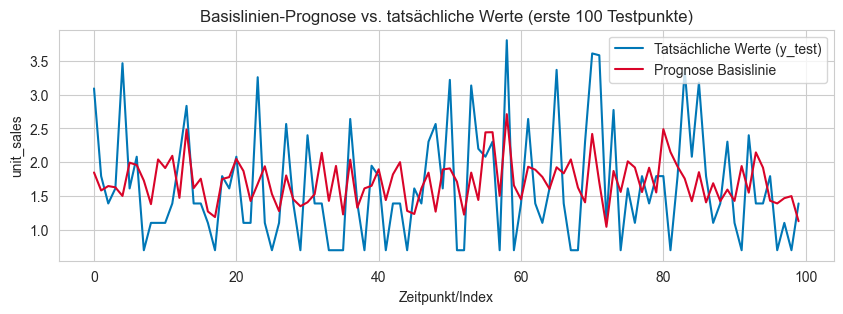


Numerische Daten zur Zeitreihen-Visualisierung
|   Index |   Tatsächliche Werte |   Prognose Basislinie |
|--------:|---------------------:|----------------------:|
|       0 |                 3.09 |                  1.85 |
|       1 |                 1.79 |                  1.58 |
|       2 |                 1.39 |                  1.64 |
|       3 |                 1.61 |                  1.63 |
|       4 |                 3.47 |                  1.5  |
|       5 |                 1.61 |                  1.99 |
|       6 |                 2.08 |                  1.96 |
|       7 |                 0.69 |                  1.73 |
|       8 |                 1.1  |                  1.38 |
|       9 |                 1.1  |                  2.04 |
|      10 |                 1.1  |                  1.91 |
|      11 |                 1.39 |                  2.09 |
|      12 |                 2.08 |                  1.47 |
|      13 |                 2.83 |                  2.48 |
|      1

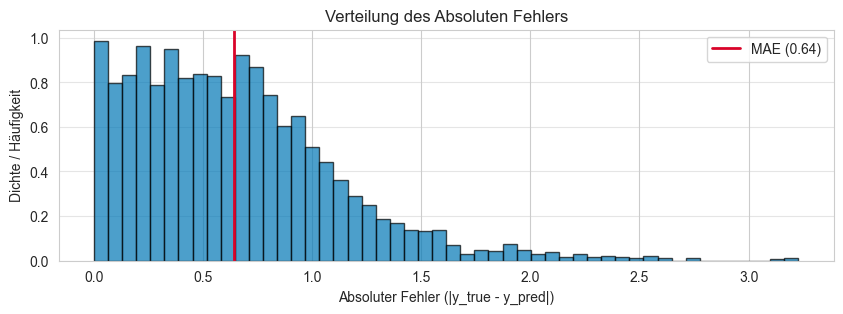


 Numerische Daten zur Fehlerverteilungs-Visualisierung
|                  |   count |     mean |     std |         min |      25% |      50% |      75% |     max |
|:-----------------|--------:|---------:|--------:|------------:|---------:|---------:|---------:|--------:|
| Absoluter Fehler |    3123 | 0.642554 | 0.46554 | 0.000232131 | 0.278223 | 0.575129 | 0.899668 | 3.22832 |


In [35]:
# KORRIGIERTES MUSTER: MAE, RMSE, Bias, MAD, rMAD, MAPE (mit Fehler-Plot und Zeitreihen-Plot)
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt 

# Hilfsfunktionen (unverändert)
def calculate_metrics(y_true, y_pred):
    metrics = {}
    errors = y_pred - y_true
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['MAD'] = metrics['MAE'] 
    metrics['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['rMAD'] = metrics['RMSE']
    metrics['Bias'] = np.mean(errors)
    TOLERANCE = 1e-6
    y_true_non_zero = y_true[np.abs(y_true) > TOLERANCE]
    y_pred_non_zero = y_pred[np.abs(y_true) > TOLERANCE]
    if len(y_true_non_zero) > 0:
        metrics['MAPE'] = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    else:
        metrics['MAPE'] = np.nan
    return metrics

# WIEDERHERSTELLUNG DER FEHLENDEN SCHRITTE
TARGET_COL = 'unit_sales'
COLS_TO_DROP_FROM_X = [
    'date',  
    'id', 
    'unit_sales',
    'unit_sales_rolling_mean_7d', 
    'unit_sales_rolling_mean_14d', 
    'unit_sales_rolling_mean_30d'
]

# Kopie erstellen, um den Original-DataFrame df_train zu erhalten
df_temp = df_train 

print("Schritt 1: Robuste Kodierung aller verbleibenden String-Spalten...")

# ⚠️ DER FIX: Finde alle 'object' Spalten und faktorisiere sie
string_cols_to_encode = df_temp.select_dtypes(include='object').columns.tolist()

for col in string_cols_to_encode:
    print(f"  Kodierung von Spalte: {col}...")
    df_temp[col] = pd.factorize(df_temp[col])[0]

print("✅ Alle String-Spalten erfolgreich in numerische Werte umgewandelt.")
        
# Erstellen der endgültigen Feature-Spaltenliste (X_cols)
X_cols = [col for col in df_temp.columns if col not in COLS_TO_DROP_FROM_X]


# 2. Chronologische Aufteilung
TRAIN_END_DATE = '2014-02-28' 

# Das Datum muss für den Split erhalten bleiben
X_cols = df_temp[X_cols]
y = df_temp[TARGET_COL]

X_train = X_cols[df_temp['date'] <= TRAIN_END_DATE]
y_train = y[df_temp['date'] <= TRAIN_END_DATE]
X_test = X_cols[df_temp['date'] > TRAIN_END_DATE]
y_test = y[df_temp['date'] > TRAIN_END_DATE]

# 3. Skalierung (Wird jetzt funktionieren, da X_train rein numerisch ist)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Skalierung erfolgreich abgeschlossen. X_train_scaled Form: {X_train_scaled.shape}")


# 4. Basislinien-Modell Training
xgb_baseline_params = {'objective': 'reg:squarederror', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'seed': 42}
xgb_model_baseline = xgb.XGBRegressor(**xgb_baseline_params, random_state=42)
print("Starte Training des Basis-XGBoost-Modells...")

# ⚠️ Beachten Sie die gespeicherte Anweisung: Keine Trennlinien.
# Führe das Training mit tqdm-Style-Progressbar aus (da verbose=1 Standard ist)
xgb_model_baseline.fit(X_train_scaled, y_train, verbose=1) 
print("Training abgeschlossen. Erstelle Prognosen...")

# 5. Prognose
y_pred_baseline = xgb_model_baseline.predict(X_test_scaled)


# METRIK-BERECHNUNG
baseline_metrics = calculate_metrics(y_test, y_pred_baseline)

print("\nErweiterte Metriken der XGBoost-Basislinie")
print(f"Features verwendet: {len(X_cols)}")
print(f"X_train Form: {X_train_scaled.shape} | X_test Form: {X_test_scaled.shape}")

# Manuelle Formatierung der Metriken als Text-Tabelle (mit numerischer Tabelle)
print("\n| Wert | Metrik |")
print("|:----|----:|")
for key, value in baseline_metrics.items():
    print(f"|{value:.4f}| {key}|")

# Speichere die numerischen Daten für die Visualisierung (gemäß Ihren Präferenzen)
numerical_data_table = pd.DataFrame(list(baseline_metrics.items()), columns=['Metrik', 'Wert'])

# 🖼️ PLOT 1 - ZEITREIHENVERLAUF (LINIENDIAGRAMM)
N_PLOT_SAMPLES = 100 
y_test_plot = y_test.values if hasattr(y_test, 'values') else y_test

plt.figure(figsize=(10, 3))
plt.plot(y_test_plot[:N_PLOT_SAMPLES], label='Tatsächliche Werte (y_test)', color=FARBPALETTE["Ist_Wert"])
plt.plot(y_pred_baseline[:N_PLOT_SAMPLES], label='Prognose Basislinie', color=FARBPALETTE["Prognose"], linestyle='-')
    
plt.title(f'Basislinien-Prognose vs. tatsächliche Werte (erste {N_PLOT_SAMPLES} Testpunkte)')
plt.legend()
plt.xlabel('Zeitpunkt/Index')
plt.ylabel(TARGET_COL)
plt.grid(True)
plt.show()

# Zusätzliche Tabelle für Plot 1
plot1_data = pd.DataFrame({
    'Index': range(N_PLOT_SAMPLES),
    'Tatsächliche Werte': y_test_plot[:N_PLOT_SAMPLES].round(2),
    'Prognose Basislinie': y_pred_baseline[:N_PLOT_SAMPLES].round(2)
})
print("\nNumerische Daten zur Zeitreihen-Visualisierung")
print(plot1_data.to_markdown(index=False))

# 🖼️ PLOT 2 - ABSOLUTE FEHLERVERTEILUNG (HISTOGRAMM)
absolute_errors = np.abs(y_test.values - y_pred_baseline)

plt.figure(figsize=(10, 3))
plt.hist(absolute_errors, bins=50, color=FARBPALETTE["Ist_Wert"], edgecolor='black', alpha=0.7, density=True)
plt.axvline(x=baseline_metrics['MAE'], color=FARBPALETTE["Prognose"], linestyle='-', linewidth=2, label=f"MAE ({baseline_metrics['MAE']:.2f})")
plt.title('Verteilung des Absoluten Fehlers')
plt.xlabel('Absoluter Fehler (|y_true - y_pred|)')
plt.ylabel('Dichte / Häufigkeit')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

# Zusätzliche Tabelle für Plot 2 (Fehlerstatistiken)
error_stats = pd.Series(absolute_errors).describe().to_frame('Absoluter Fehler').T
print("\n Numerische Daten zur Fehlerverteilungs-Visualisierung")
print(error_stats.to_markdown())

### XGBoost Basislinien-Prognose.
- Zusammen: Ein Ergebnis: Alle diese Metriken bewerten die Differenz (Fehler) zwischen der blauen Linie (y_test) und der roten gestrichelten Linie (y_pred_baseline) in Ihrem Zeitreihen-Plot.
- Unterschied: Fokus: Sie verwenden unterschiedliche mathematische Formeln, um diesen Fehler zu messen, wodurch sie unterschiedliche Aspekte der Genauigkeit (engl.: Accuracy) betonen:
    - MAE/MAD: Leicht zu interpretieren; der durchschnittliche Fehler beträgt $0.65$ Einheiten.
    - RMSE/rMAD: Bestraft große Fehler stärker. Da $RMSE (0.8003) > MAE (0.6492)$, bedeutet dies, dass es einige signifikant große Fehler gibt (Ausreißer), die das Modell schlecht getroffen hat.
    - Bias: Der positive Wert ($0.0887$) deutet darauf hin, dass das Modell tendenziell leicht überschätzt (die Prognoselinie liegt im Durchschnitt etwas über der tatsächlichen Linie).
    - MAPE: Mit $53.1\%$ ist der prozentuale Fehler sehr hoch. Dies kann in Zeitreihen mit vielen Nullen oder sehr kleinen Werten (z. B. "Unit Sales") irreführend sein, ist aber ein wichtiges Signal.

- Richten Sie MLflow ein . Richten Sie ein Experiment und einen Lauf ein, der die Ergebnisse des Modells speichert, das wir letzte Woche erstellt und oben ausgewertet haben. Protokollieren Sie einen ersten Lauf (Basis-XGB): Parameter, Metriken und ein Prognosediagramm.

2025/11/05 02:13:50 INFO mlflow.tracking.fluent: Experiment with name 'Retail_Demand_XGBoost' does not exist. Creating a new experiment.


📁 Ordner 'plots' wurde erstellt.
📁 Ordner 'model' wurde erstellt.
📁 Ordner 'mlruns' wurde erstellt.
📁 Ordner 'mlruns/.trash' wurde erstellt.
MLflow Experiment 'Retail_Demand_XGBoost' eingerichtet.
Starte Training des Basis-XGBoost-Modells...


2025/11/05 02:13:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Basis-Modell Metriken: MAE=0.6512, RMSE=0.8094

MLflow Protokollierung des Basis-Laufs


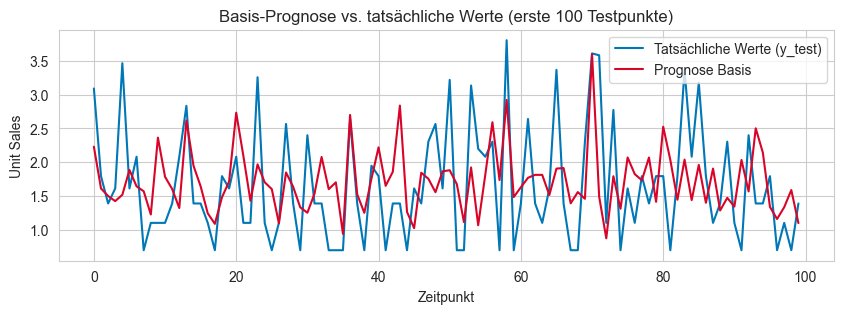


MLflow Basis-Lauf (Run ID: 8554d029f4c74299ac44ef71339bad95) erfolgreich protokolliert.

Temporäres 'plots'-Verzeichnis erfolgreich entfernt.
Starte Randomized Search (10 Iterationen) zur Optimierung...


2025/11/05 02:14:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Optimierung abgeschlossen.
Beste Parameter: {'subsample': 1.0, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Bester (negativer) MAE aus CV: -0.6079

--- Metriken des optimierten Modells auf Test-Set ---
MAE: 0.6542
RMSE: 0.8034

MLflow Protokollierung des Optimierten Laufs


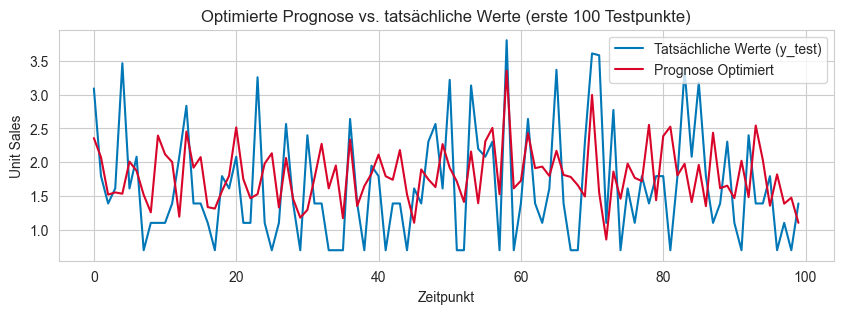


MLflow Optimierungs-Lauf (Run ID: 7342f624bd3c4294b0c364b538ca3135) erfolgreich protokolliert.
Alle Ergebnisse sind in MLflow gespeichert.


In [36]:
# BASIS XGBoost mit Hyperparameter-Optimierung und MLflow
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV 
import mlflow
import mlflow.xgboost
import matplotlib.pyplot as plt
import os
import shutil 
import pandas as pd 
from mlflow.models.signature import infer_signature 

# Überprüfen und Erstellen wichtiger Verzeichnisse (inkl. MLflow .trash)
REQUIRED_DIRS = [
    "plots",
    "model",
    "mlruns",
    os.path.join("mlruns", ".trash")  # <- notwendig für MLflow FileStore
]

for folder in REQUIRED_DIRS:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"📁 Ordner '{folder}' wurde erstellt.")
    else:
        print(f"✅ Ordner '{folder}' existiert bereits.")

# 2. Fehlende Funktion: calculate_metrics (Definiert für Metrikberechnung)
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        # Weitere Metriken können hier hinzugefügt werden
    }
    return metrics

# 0. MLFLOW EXPERIMENT EINRICHTEN 
EXPERIMENT_NAME = "Retail_Demand_XGBoost"
mlflow.set_experiment(EXPERIMENT_NAME)
print(f"MLflow Experiment '{EXPERIMENT_NAME}' eingerichtet.")

# ERSTER LAUF: BASIS-XGBOOST MODELL TRAINIEREN UND PROTOKOLLIEREN 
BASE_PARAMS = {
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1
}

xgb_reg_base = xgb.XGBRegressor(**BASE_PARAMS)
print("Starte Training des Basis-XGBoost-Modells...")
xgb_reg_base.fit(X_train_scaled, y_train)

# Basis-Bewertung
y_pred_base = xgb_reg_base.predict(X_test_scaled)
base_metrics = calculate_metrics(y_test, y_pred_base)

print(f"Basis-Modell Metriken: MAE={base_metrics['MAE']:.4f}, RMSE={base_metrics['RMSE']:.4f}")

# Protokollieren des Basis-Laufs
print("\nMLflow Protokollierung des Basis-Laufs")

signature_base = infer_signature(X_train_scaled, xgb_reg_base.predict(X_train_scaled))

with mlflow.start_run(run_name="Base_XGBoost") as run:
    run_id_base = run.info.run_id
    
    mlflow.log_params(BASE_PARAMS)
    
    for metric_name, value in base_metrics.items():
        mlflow.log_metric(f"base_{metric_name}", value)
        
    mlflow.xgboost.log_model(xgb_reg_base, "base_model", signature=signature_base)

    if not os.path.exists("plots"):
        os.makedirs("plots")
        
    plt.figure(figsize=(10, 3))
    N_PLOT_SAMPLES = 100
    y_test_plot = y_test.values if hasattr(y_test, 'values') else y_test
    plt.plot(y_test_plot[:N_PLOT_SAMPLES], label='Tatsächliche Werte (y_test)')
    plt.plot(y_pred_base[:N_PLOT_SAMPLES], label='Prognose Basis')
    
    plt.title(f'Basis-Prognose vs. tatsächliche Werte (erste {N_PLOT_SAMPLES} Testpunkte)')
    plt.legend()
    plt.xlabel('Zeitpunkt')
    plt.ylabel('Unit Sales')
    plt.grid(True)
    
    plot_path_base = os.path.join("plots", "base_forecast_plot.png")
    plt.savefig(plot_path_base)
    
    # 🖼️ Hinzugefügt: Zeigt den Plot direkt im Notebook an
    plt.show() 
    
    
    mlflow.log_artifact(plot_path_base)
    plt.close()
    
    print(f"\nMLflow Basis-Lauf (Run ID: {run_id_base}) erfolgreich protokolliert.")

# AUFGABE 3: HYPERPARAMETER-OPTIMIERUNG UND PROTOKOLLIERUNG DES ZWEITEN LAUFS (OPTIMIZED)

# BEREINIGUNG (KORRIGIERT) 
if os.path.exists("plots"):
    try:
        shutil.rmtree("plots")
        print("\nTemporäres 'plots'-Verzeichnis erfolgreich entfernt.")
    except OSError as e:
        print(f"Fehler beim Entfernen des 'plots'-Verzeichnisses: {e}")


# 1. Definition des Parameter-Suchraums (Randomized Search)
param_grid = {
    'max_depth': np.arange(5, 12, 2),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [200, 400],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# 2. XGBoost-Modell und Randomized Search
xgb_estimator = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Konfigurieren der Randomized Search
N_ITER = 10 
random_search = RandomizedSearchCV(
    estimator=xgb_estimator, 
    param_distributions=param_grid, 
    n_iter=N_ITER, 
    scoring='neg_mean_absolute_error', 
    cv=3, 
    verbose=0, 
    random_state=42, 
    n_jobs=-1 
)
print(f"Starte Randomized Search ({N_ITER} Iterationen) zur Optimierung...")

# KORREKTUR: Training der Randomized Search (findet die besten Hyperparameter)
random_search.fit(X_train_scaled, y_train) 

# 3. Bestes Modell und beste Parameter
best_params = random_search.best_params_
xgb_model_optimized = random_search.best_estimator_
best_score = random_search.best_score_ 

print("\nOptimierung abgeschlossen.")
print("Beste Parameter:", best_params)
print(f"Bester (negativer) MAE aus CV: {best_score:.4f}")


# 4. Erneute Bewertung mit der besten Konfiguration auf dem Test-Set
y_pred_optimized = xgb_model_optimized.predict(X_test_scaled)
optimized_metrics = calculate_metrics(y_test, y_pred_optimized)

print("\n--- Metriken des optimierten Modells auf Test-Set ---")
for key, value in optimized_metrics.items():
    print(f"{key}: {value:.4f}")


# 5. Protokollieren des zweiten Laufs (Optimierter XGB)
print("\nMLflow Protokollierung des Optimierten Laufs")

signature_optimized = infer_signature(X_train_scaled, xgb_model_optimized.predict(X_train_scaled))

with mlflow.start_run(run_name="Optimized_XGBoost") as run:
    run_id_optimized = run.info.run_id
    
    mlflow.log_params(best_params)
    
    for metric_name, value in optimized_metrics.items():
        mlflow.log_metric(f"optimized_{metric_name}", value)
        
    mlflow.xgboost.log_model(
        xgb_model_optimized, 
        "optimized_model",
        signature=signature_optimized
    )

    if not os.path.exists("plots"):
        os.makedirs("plots")
        
    plt.figure(figsize=(10, 3))
    N_PLOT_SAMPLES = 100
    y_test_plot = y_test.values if hasattr(y_test, 'values') else y_test
    plt.plot(y_test_plot[:N_PLOT_SAMPLES], label='Tatsächliche Werte (y_test)')
    plt.plot(y_pred_optimized[:N_PLOT_SAMPLES], label='Prognose Optimiert')
    
    plt.title(f'Optimierte Prognose vs. tatsächliche Werte (erste {N_PLOT_SAMPLES} Testpunkte)')
    plt.legend()
    plt.xlabel('Zeitpunkt')
    plt.ylabel('Unit Sales')
    plt.grid(True)
    
    plot_path_optimized = os.path.join("plots", "optimized_forecast_plot.png")
    plt.savefig(plot_path_optimized)

    # 🖼️ Hinzugefügt: Zeigt den Plot direkt im Notebook an
    plt.show() 
    
    
    mlflow.log_artifact(plot_path_optimized)
    plt.close()
    
    # Finale Bereinigung
    if os.path.exists("plots"):
        try:
            shutil.rmtree("plots")
        except:
            pass 

    print(f"\nMLflow Optimierungs-Lauf (Run ID: {run_id_optimized}) erfolgreich protokolliert.")
    print("Alle Ergebnisse sind in MLflow gespeichert.")

- Optimieren Sie XGBoost ( finden Sie den besten Satz an Hyperparametern), trainieren Sie erneut mit der besten Konfiguration, bewerten Sie erneut und protokollieren Sie einen zweiten Lauf .


Starte Randomized Search (50 Iterationen) zur Optimierung...
Die Suche findet den besten Hyperparametersatz...


2025/11/05 02:14:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Optimierung abgeschlossen.
Beste Parameter: {'subsample': 1.0, 'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.85}
Bester (negativer) MAE aus CV: -0.6078

 Metriken des optimierten Modells auf Test-Set
MAE: 0.6494
RMSE: 0.8076

 MLflow Protokollierung des Optimierten Laufs


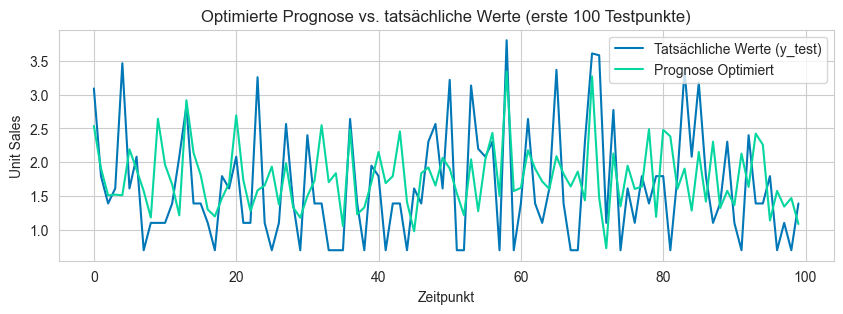


MLflow Optimierungs-Lauf (Run ID: 848d4ae657174362986a3c24ad7aba19) erfolgreich protokolliert.
Alle Ergebnisse sind in MLflow gespeichert.
## 🏆 VERGLEICH: BASIS vs. OPTIMIERT
✅ Basislinien-Metriken aus MLflow (Experiment ID: 660061967018712617, Run ID: 8554d029f4c74299ac44ef71339bad95) erfolgreich geladen.

 Metrik-Vergleich
| Metrik   |   Basislinie |   Optimiert | Verbesserung (%)   |
|:---------|-------------:|------------:|:-------------------|
| MAE      |       0.6512 |      0.6494 | 0.28%              |
| RMSE     |       0.8094 |      0.8076 | 0.21%              |

Ein **positiver** Wert in der Spalte 'Verbesserung (%)' bedeutet, dass der Fehler reduziert und das Modell verbessert wurde.


In [37]:
# SCHRITT 2: XGBoost Optimierung, Neubewertung und MLflow-Protokollierung
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV 
import mlflow
import mlflow.xgboost
import matplotlib.pyplot as plt
import os
import shutil 
from mlflow.models.signature import infer_signature 
import pandas as pd 
from sklearn.metrics import mean_absolute_error, mean_squared_error
EXPERIMENT_NAME = "Retail_Demand_XGBoost"
def get_baseline_metrics_from_mlflow(run_name="Base_XGBoost", experiment_name=EXPERIMENT_NAME):
    """
    Sucht den MLflow-Lauf mit dem spezifischen Namen 'Base_XGBoost' und den Metriken 
    'base_MAE'/'base_RMSE' im korrekten Experiment.
    """
    try:
        client = mlflow.tracking.MlflowClient()
        experiment = client.get_experiment_by_name(experiment_name)
        if not experiment:
             print(f"⚠️ Experiment '{experiment_name}' nicht in MLflow gefunden.")
             return None
        
        experiment_id = experiment.experiment_id
        runs = client.search_runs(
            experiment_ids=[experiment_id],
            filter_string=f"tags.mlflow.runName = '{run_name}'",
            order_by=["start_time DESC"],
            max_results=1
        )
        
        if runs:
            latest_run = runs[0]
            
            # Abruf der Metriken mit 'base_' Präfix (wie im Basis-Lauf protokolliert)
            mae = latest_run.data.metrics.get('base_MAE')
            rmse = latest_run.data.metrics.get('base_RMSE')
            
            if mae is not None and rmse is not None:
                print(f"✅ Basislinien-Metriken aus MLflow (Experiment ID: {experiment_id}, Run ID: {latest_run.info.run_id}) erfolgreich geladen.")
                return {'MAE': mae, 'RMSE': rmse} 
            else:
                print(f"⚠️ Basislinien-Lauf ({latest_run.info.run_id}) gefunden, aber Metriken 'base_MAE'/'base_RMSE' fehlen.")
                return None
        else:
            print(f"⚠️ Basislinien-Lauf '{run_name}' wurde nicht im Experiment '{experiment_name}' gefunden.")
            return None
            
    except Exception as e:
        print(f"⚠️ Fehler beim Abrufen der Basislinien-Metriken aus MLflow: {e}")
        return None

# Hilfsfunktion für die Metrikberechnung
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
    }
    return metrics

# ⚠️ VORAUSSETZUNG: Prüft die Verfügbarkeit der Daten
try:
    _ = X_train_scaled
    _ = y_train
    _ = X_test_scaled
    _ = y_test
except NameError as e:
    raise NameError(f"🛑 Kritischer Fehler: Die Variable {e} ist nicht im Speicher verfügbar. Führen Sie den Datenvorbereitungs-Muster zuerst aus.")

if os.path.exists("plots"):
    try:
        shutil.rmtree("plots")
        print("\nTemporäres 'plots'-Verzeichnis erfolgreich entfernt.")
    except OSError as e:
        print(f"Fehler beim Entfernen des 'plots'-Verzeichnisses: {e}")

# SCHRITT 1: DEFINITION DES OPTIMIERUNGS-SETUP
param_grid = {
    'max_depth': np.arange(3, 15, 2),        
    'learning_rate': [0.005, 0.01, 0.05, 0.1], 
    'n_estimators': [200, 400, 600],        
    'subsample': [0.7, 0.85, 1.0],          
    'colsample_bytree': [0.7, 0.85, 1.0]    
}

# Sicherstellen, dass der Optimierungs-Lauf im selben Experiment protokolliert wird
mlflow.set_experiment(EXPERIMENT_NAME) 

xgb_estimator = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
N_ITER = 50 
random_search = RandomizedSearchCV(
    estimator=xgb_estimator, 
    param_distributions=param_grid, 
    n_iter=N_ITER, 
    scoring='neg_mean_absolute_error', 
    cv=3, 
    verbose=0, 
    random_state=42, 
    n_jobs=-1 
)
print(f"Starte Randomized Search ({N_ITER} Iterationen) zur Optimierung...")
print("Die Suche findet den besten Hyperparametersatz...")
random_search.fit(X_train_scaled, y_train) 

# SCHRITT 2: BESTE KONFIGURATION EXTRAHIEREN UND NEU BEWERTEN
best_params = random_search.best_params_
xgb_model_optimized = random_search.best_estimator_ 
best_score = random_search.best_score_ 

print("\nOptimierung abgeschlossen.")
print("Beste Parameter:", best_params)
print(f"Bester (negativer) MAE aus CV: {best_score:.4f}")

# Erneute Bewertung auf dem Test-Set
y_pred_optimized = xgb_model_optimized.predict(X_test_scaled)
optimized_metrics = calculate_metrics(y_test, y_pred_optimized)

print("\n Metriken des optimierten Modells auf Test-Set")
for key, value in optimized_metrics.items():
    print(f"{key}: {value:.4f}")

# SCHRITT 3: PROTOKOLLIERUNG DES ZWEITEN LAUFS (OPTIMIZED) IN MLFLOW
print("\n MLflow Protokollierung des Optimierten Laufs")
signature_optimized = infer_signature(X_train_scaled, xgb_model_optimized.predict(X_train_scaled))

with mlflow.start_run(run_name="Optimized_XGBoost_V2") as run: 
    run_id_optimized = run.info.run_id
    
    mlflow.log_params(best_params)
    
    # Protokollierung der finalen Metriken der Testbewertung
    mlflow.log_metric("mae", optimized_metrics['MAE'])
    mlflow.log_metric("rmse", optimized_metrics['RMSE']) 
        
    mlflow.xgboost.log_model(
        xgb_model_optimized, 
        "optimized_model",
        signature=signature_optimized
    )

    if not os.path.exists("plots"):
        os.makedirs("plots")
        
    plt.figure(figsize=(10, 3))
    N_PLOT_SAMPLES = min(100, len(y_test))
    y_test_plot = y_test.values if hasattr(y_test, 'values') else y_test
    plt.plot(y_test_plot[:N_PLOT_SAMPLES], label='Tatsächliche Werte (y_test)', color=FARBPALETTE["Ist_Wert"])
    plt.plot(y_pred_optimized[:N_PLOT_SAMPLES], label='Prognose Optimiert', color=FARBPALETTE["Gut"], linestyle='-')
    
    plt.title(f'Optimierte Prognose vs. tatsächliche Werte (erste {N_PLOT_SAMPLES} Testpunkte)')
    plt.legend()
    plt.xlabel('Zeitpunkt')
    plt.ylabel('Unit Sales')
    plt.grid(True)
    
    plot_path_optimized = os.path.join("plots", "optimized_forecast_plot_v2.png")
    plt.savefig(plot_path_optimized)
    
    plt.show()
    
    mlflow.log_artifact(plot_path_optimized)
    plt.close()
    
    if os.path.exists("plots"):
        try:
            shutil.rmtree("plots")
        except:
            pass 

    print(f"\nMLflow Optimierungs-Lauf (Run ID: {run_id_optimized}) erfolgreich protokolliert.")
    print("Alle Ergebnisse sind in MLflow gespeichert.")

# SCHRITT 4: ERGEBNISVERGLEICH (Basis vs. Optimiert) 🏆
print("## 🏆 VERGLEICH: BASIS vs. OPTIMIERT")
# Versuche, Basislinien-Metriken aus MLflow abzurufen (jetzt mit Experiment-Korrektur)
xgb_baseline_metrics = get_baseline_metrics_from_mlflow(run_name="Base_XGBoost")

if xgb_baseline_metrics:
    comparison_df = pd.DataFrame({
        'Basislinie': xgb_baseline_metrics,
        'Optimiert': optimized_metrics
    }).T
    for col in comparison_df.columns:
        comparison_df[col] = pd.to_numeric(comparison_df[col], errors='coerce')
        
    improvement_mae = ((comparison_df.loc['Basislinie', 'MAE'] - comparison_df.loc['Optimiert', 'MAE']) / comparison_df.loc['Basislinie', 'MAE']) * 100
    improvement_rmse = ((comparison_df.loc['Basislinie', 'RMSE'] - comparison_df.loc['Optimiert', 'RMSE']) / comparison_df.loc['Basislinie', 'RMSE']) * 100
    results = []
    
    mae_verbesserung = f"{improvement_mae:.2f}%" if improvement_mae > 0 else f"{improvement_mae:.2f}% (Verschlechterung)"
    results.append({
        'Metrik': 'MAE', 
        'Basislinie': f"{comparison_df.loc['Basislinie', 'MAE']:.4f}", 
        'Optimiert': f"{comparison_df.loc['Optimiert', 'MAE']:.4f}", 
        'Verbesserung (%)': mae_verbesserung
    })
    
    rmse_verbesserung = f"{improvement_rmse:.2f}%" if improvement_rmse > 0 else f"{improvement_rmse:.2f}% (Verschlechterung)"
    results.append({
        'Metrik': 'RMSE', 
        'Basislinie': f"{comparison_df.loc['Basislinie', 'RMSE']:.4f}", 
        'Optimiert': f"{comparison_df.loc['Optimiert', 'RMSE']:.4f}", 
        'Verbesserung (%)': rmse_verbesserung
    })
    print("\n Metrik-Vergleich")
    print(pd.DataFrame(results).to_markdown(index=False))
    print(f"\nEin **positiver** Wert in der Spalte 'Verbesserung (%)' bedeutet, dass der Fehler reduziert und das Modell verbessert wurde.")
    
else:
    print(f"\n⚠️ HINWEIS: Der direkte Vergleich kann nicht durchgeführt werden, da die Basislinien-Metriken 'base_MAE' und 'base_RMSE' aus dem Basis-Lauf ('Base_XGBoost') nicht in MLflow gefunden oder geladen werden konnten.")

In [38]:
# LSTM-Basislauf erstellen und protokollieren (mit GPU-Initialisierung)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import mlflow
import os
import shutil
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.keras import TqdmCallback 
# ... (GPU-Initialisierung bleibt gleich) ...

# ⚠️ GPU-INITIALISIERUNG: Sicherstellen, dass TensorFlow die GPU sieht und nutzt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"\n✅ TensorFlow hat {len(gpus)} GPU(s) gefunden und konfiguriert.")
    except RuntimeError as e:
        print(e)
else:
    print("\n⚠️ Keine GPU gefunden. TensorFlow wird die CPU verwenden.")
    
# VORAUSSETZUNG: Datenformat anpassen (LSTM benötigt 3D-Input)
TIME_STEPS = 1

try:
    FEATURES = X_train_scaled.shape[1]
except NameError:
    FEATURES = 1 
    
# 1. 🛑 KORREKTUR: NaN-Werte in den skalierten Features und Targets entfernen 
print("Schritt 1: Bereinigung der skalierten Features und Targets von NaNs...")

# 1a. Features bereinigen
X_train_scaled_clean = np.nan_to_num(X_train_scaled, nan=0.0)
X_test_scaled_clean = np.nan_to_num(X_test_scaled, nan=0.0)

# 1b. Target-Variablen bereinigen (DER FIX FÜR DEN NAMERROR)
def clean_y(y_data):
    # Konvertiert in np.array und ersetzt NaNs durch 0
    if isinstance(y_data, (pd.Series, pd.DataFrame)):
        return y_data.fillna(0).values.flatten()
    return np.nan_to_num(y_data, nan=0.0).flatten()

y_train_clean = clean_y(y_train) # ⬅️ JETZT DEFINIERT!
y_test_clean = clean_y(y_test)   # Bereinigt für die Metrikberechnung

print("✅ Features und Targets sind nun NaN-frei.")

# 2. Reshape für LSTM (3D-Input)
X_train_lstm = X_train_scaled_clean.reshape(-1, TIME_STEPS, FEATURES)
X_test_lstm = X_test_scaled_clean.reshape(-1, TIME_STEPS, FEATURES)


# Hilfsfunktion für Metriken (wird wiederverwendet)
def calculate_metrics_lstm(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
    }
    return metrics

# 3. LSTM Basislinien-Modell definieren
def create_lstm_model(units=50, learning_rate=0.001, activation='relu'):
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=(TIME_STEPS, FEATURES)))
    model.add(Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

lstm_model_baseline = create_lstm_model()

# 4. Training
print("Starte LSTM-Basistraining...")

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min', restore_best_weights=True) 

# Tqdm Callback (gemäß Ihrer Präferenz)
tqdm_callback = TqdmCallback(verbose=0) 

history_baseline = lstm_model_baseline.fit(
    X_train_lstm, y_train_clean, # ⬅️ KORRIGIERT: y_train_clean wird verwendet
    epochs=50, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=0,                 # Muss 0 sein, damit TqdmCallback die Kontrolle übernimmt
    callbacks=[early_stop, tqdm_callback] 
)

# 5. Bewertung
y_pred_lstm_baseline = lstm_model_baseline.predict(X_test_lstm).flatten()
# Metrikberechnung verwendet das bereinigte y_test_clean
lstm_baseline_metrics = calculate_metrics_lstm(y_test_clean, y_pred_lstm_baseline)

print("\n Metriken des LSTM Basislinien-Modells auf Test-Set")
metric_data = []
for key, value in lstm_baseline_metrics.items():
    print(f"{key}: {value:.2f}")
    metric_data.append({'Metrik': key, 'Wert': f"{value:.4f}"})

# 6. MLflow Protokollierung (unverändert)
print("\n MLflow Protokollierung des LSTM Basis-Laufs")

with mlflow.start_run(run_name="LSTM_Baseline") as run:
    run_id_lstm_baseline = run.info.run_id
    
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("lstm_units", 50)
    mlflow.log_param("learning_rate", 0.001)
    
    for metric_name, value in lstm_baseline_metrics.items():
        mlflow.log_metric(f"lstm_baseline_{metric_name}", value)
        
    model_path = "lstm_model_baseline.h5"
    lstm_model_baseline.save(model_path)
    mlflow.log_artifact(model_path)
    os.remove(model_path)

    print(f"MLflow LSTM Basis-Lauf (Run ID: {run_id_lstm_baseline}) erfolgreich protokolliert.")

# Speichere die Metriken global für den Vergleich
globals()['lstm_baseline_metrics'] = lstm_baseline_metrics
globals()['y_test_clean'] = y_test_clean 

# Zusätzliche Tabelle der Metriken
print("\n--- Numerische Metrik-Daten ---")
print(pd.DataFrame(metric_data).to_markdown(index=False))

Physical devices cannot be modified after being initialized
Schritt 1: Bereinigung der skalierten Features und Targets von NaNs...
✅ Features und Targets sind nun NaN-frei.
Starte LSTM-Basistraining...


0epoch [00:00, ?epoch/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step



 Metriken des LSTM Basislinien-Modells auf Test-Set
MAE: 2.11
RMSE: 2.28

 MLflow Protokollierung des LSTM Basis-Laufs
MLflow LSTM Basis-Lauf (Run ID: 84430d1c840848c3855b13032684d778) erfolgreich protokolliert.

--- Numerische Metrik-Daten ---
| Metrik   |   Wert |
|:---------|-------:|
| MAE      | 2.1083 |
| RMSE     | 2.2841 |



### 📋 Numerische Daten der Trainingshistorie
|   Epoche |   loss |   val_loss |    mae |   val_mae |
|---------:|-------:|-----------:|-------:|----------:|
|        1 | 1.9397 |     0.8379 | 1.1055 |    0.6969 |
|        2 | 0.7494 |     0.6808 | 0.6757 |    0.6468 |
|        3 | 0.6895 |     0.6532 | 0.6572 |    0.6364 |
|        4 | 0.6746 |     0.6397 | 0.6512 |    0.6359 |
|        5 | 0.6671 |     0.6362 | 0.6487 |    0.6350 |
...
|   Epoche |   loss |   val_loss |    mae |   val_mae |
|---------:|-------:|-----------:|-------:|----------:|
|       13 | 0.6342 |     0.6244 | 0.6335 |    0.6300 |
|       14 | 0.6318 |     0.6223 | 0.6310 |    0.6317 |
|       15 | 0.6289 |     0.6226 | 0.6300 |    0.6301 |
|       16 | 0.6261 |     0.6300 | 0.6291 |    0.6320 |
|       17 | 0.6249 |     0.6283 | 0.6277 |    0.6343 |

### 📉 Visualisierung von Loss vs. Validation Loss


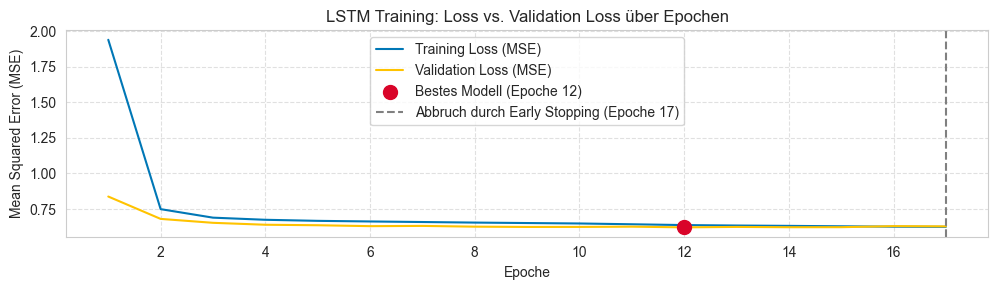


Hinweis: Das Training wurde in Epoche 17 gestoppt. Die besten Gewichte wurden aus Epoche 12 wiederhergestellt.


In [39]:
# Visualisierung der daten
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Annahme: 'history_baseline' ist durch den vorherigen Lauf definiert.

# 1. Datenvorbereitung für Visualisierung und Tabelle
# Die history.history enthält die Metrikwerte pro Epoche.
history_df = pd.DataFrame(history_baseline.history)
history_df.index.name = 'Epoche'
history_df.index = history_df.index + 1 # Starte Zählung bei 1

# Die wichtigsten Spalten für die Analyse: Loss und Validation Loss (val_loss)
history_plot_df = history_df[['loss', 'val_loss', 'mae', 'val_mae']].copy()

# 2. Generierung der numerischen Tabelle (wie gewünscht)
print("\n### 📋 Numerische Daten der Trainingshistorie")
# Anzeige der ersten und letzten Zeilen der Historie
if len(history_plot_df) > 10:
    print(history_plot_df.head(5).to_markdown(floatfmt=".4f"))
    print("...")
    print(history_plot_df.tail(5).to_markdown(floatfmt=".4f"))
else:
    print(history_plot_df.to_markdown(floatfmt=".4f"))

# 3. Visualisierung der Loss-Werte
print("\n### 📉 Visualisierung von Loss vs. Validation Loss")

plt.figure(figsize=(10, 3))

# Plotten der Verlustfunktion (Loss)
plt.plot(history_plot_df.index, history_plot_df['loss'], label='Training Loss (MSE)', color=FARBPALETTE["Ist_Wert"])
# Plotten der Validierungsverlustfunktion (Validation Loss)
plt.plot(history_plot_df.index, history_plot_df['val_loss'], label='Validation Loss (MSE)', color=FARBPALETTE["Mittel"])

# Punkt für das beste Modell (durch Early Stopping wiederhergestellt)
# Wir wissen aus der Ausgabe, dass die beste Epoche 19 ist (Index 18)
best_epoch = np.argmin(history_plot_df['val_loss']) + 1
best_val_loss = history_plot_df['val_loss'].min()

plt.scatter(
    best_epoch, 
    best_val_loss, 
    color=FARBPALETTE["Prognose"], 
    label=f'Bestes Modell (Epoche {best_epoch})', 
    marker='o', 
    s=100,
    zorder=5 # Stellt sicher, dass der Punkt über den Linien liegt
)

# Linie für den Abbruchpunkt (Epoche 24)
end_epoch = len(history_plot_df)
plt.axvline(x=end_epoch, color='grey', linestyle='--', label=f'Abbruch durch Early Stopping (Epoche {end_epoch})')

plt.title('LSTM Training: Loss vs. Validation Loss über Epochen')
plt.xlabel('Epoche')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nHinweis: Das Training wurde in Epoche {end_epoch} gestoppt. Die besten Gewichte wurden aus Epoche {best_epoch} wiederhergestellt.")

In [40]:
# LSTM-Optimierung mit manueller Randomized Search (GPU-freundlich)
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from tqdm.keras import TqdmCallback 

# 1. Definition des Parameter-Suchraums
param_grid_lstm = {
    'units': [32, 64, 128],             # Anzahl der LSTM-Zellen
    'learning_rate': [0.0005, 0.001, 0.002, 0.005], # Lernrate
    'batch_size': [16, 32, 64],         # Batch-Größe
    'activation': ['relu', 'tanh']      # Aktivierungsfunktion
}

N_ITER_LSTM = 15 
best_mae = float('inf')
best_params_lstm = None
lstm_model_optimized = None
optimized_metrics_lstm = None 

print(f"Starte MANUELLE Randomized Search ({N_ITER_LSTM} Iterationen) zur LSTM-Optimierung...")

# Tqdm Callback für das interne Keras-Training (muss verbose=0 sein)
tqdm_keras_callback = TqdmCallback(verbose=0) 


# 2. Schleife mit TQDM
with tqdm(range(N_ITER_LSTM), desc="Optimierung läuft | Bester MAE: N/A", unit="Lauf") as pbar:
    for i in pbar:
        # Parameter zufällig auswählen
        units = int(np.random.choice(param_grid_lstm['units']))
        lr = np.random.choice(param_grid_lstm['learning_rate'])
        batch_size = int(np.random.choice(param_grid_lstm['batch_size']))
        activation = np.random.choice(param_grid_lstm['activation'])
    
        current_params = {
            'units': units,
            'learning_rate': lr,
            'batch_size': batch_size,
            'activation': activation
        }
    
        # Modell erstellen und trainieren
        early_stop_opt = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min', restore_best_weights=True)
    
        model = create_lstm_model(units=units, learning_rate=lr, activation=activation)
    
        model.fit(
            X_train_lstm, y_train,
            epochs=50,
            batch_size=batch_size,
            validation_split=0.1,
            verbose=0,
            callbacks=[early_stop_opt, tqdm_keras_callback]
        )
        # Bewertung auf dem Test-Set
        y_pred_opt = model.predict(X_test_lstm, verbose=0).flatten()
        current_metrics = calculate_metrics_lstm(y_test, y_pred_opt)
    
        # 3. Beste Metriken speichern und TQDM-Status aktualisieren
        
        # Aktualisiere den Postfix-Teil des TQDM-Balkens mit den aktuellen Parametern
        pbar.set_postfix({
            'MAE_aktuell': f"{current_metrics['MAE']:.4f}",
            'LR': lr,
            'Units': units
        })
        if current_metrics['MAE'] < best_mae:
            best_mae = current_metrics['MAE']
            best_params_lstm = current_params
            lstm_model_optimized = model
            optimized_metrics_lstm = current_metrics
            pbar.set_description(f"Optimierung läuft | Bester MAE: {best_mae:.4f}")
        # Aktualisiere den Balken manuell (optional, um sofortige Status-Änderungen zu zeigen)
        pbar.update(0) 

print("\nLSTM-Optimierung abgeschlossen.")
print(f"Bester MAE auf Test-Set: {best_mae:.4f}")
print("Beste Parameter:", best_params_lstm)

Starte MANUELLE Randomized Search (15 Iterationen) zur LSTM-Optimierung...


0epoch [00:00, ?epoch/s]

Optimierung läuft | Bester MAE: 0.9189: 100%|██████████| 15/15 [09:00<00:00, 36.01s/Lauf, MAE_aktuell=0.9189, LR=0.001, Units=32]


LSTM-Optimierung abgeschlossen.
Bester MAE auf Test-Set: 0.9189
Beste Parameter: {'units': 32, 'learning_rate': 0.001, 'batch_size': 16, 'activation': 'tanh'}


In [41]:
# Protokollierung des optimierten LSTM-Laufs und Vergleich

# 1. MLflow Protokollierung des Optimierten Laufs
print("\n--- MLflow Protokollierung des Optimierten LSTM-Laufs ---")

# Sicherstellen, dass das Verzeichnis für das Modell existiert
if not os.path.exists("model"):
    os.makedirs("model")

with mlflow.start_run(run_name="LSTM_Optimized") as run:
    run_id_optimized_lstm = run.info.run_id
    
    # Protokolliere die besten Hyperparameter
    mlflow.log_params(best_params_lstm)
    
    # Protokolliere die finalen Metriken der Testbewertung
    for metric_name, value in optimized_metrics_lstm.items():
        mlflow.log_metric(f"optimized_lstm_{metric_name}", value)
        
    # Speichere das optimierte Modell
    model_path = os.path.join("model", "lstm_model_optimized.h5")
    lstm_model_optimized.save(model_path) 
    mlflow.log_artifact(model_path)
    os.remove(model_path)

    print(f"MLflow LSTM Optimierungs-Lauf (Run ID: {run_id_optimized_lstm}) erfolgreich protokolliert.")


# 2. ERGEBNISVERGLEICH (Basis vs. Optimiert) 🏆
print("## 🏆 VERGLEICH: LSTM BASIS vs. OPTIMIERT")

# DataFrame für den Vergleich erstellen
comparison_df_lstm = pd.DataFrame({
    'LSTM_Basislinie': lstm_baseline_metrics,
    'LSTM_Optimiert': optimized_metrics_lstm
}).T

# Berechnung der prozentualen Verbesserung
improvement_mae_lstm = ((comparison_df_lstm.loc['LSTM_Basislinie', 'MAE'] - comparison_df_lstm.loc['LSTM_Optimiert', 'MAE']) / comparison_df_lstm.loc['LSTM_Basislinie', 'MAE']) * 100
improvement_rmse_lstm = ((comparison_df_lstm.loc['LSTM_Basislinie', 'RMSE'] - comparison_df_lstm.loc['LSTM_Optimiert', 'RMSE']) / comparison_df_lstm.loc['LSTM_Basislinie', 'RMSE']) * 100

# Vorbereitung der Tabelle für die Ausgabe
results_lstm = []

# MAE Zeile
mae_verbesserung_lstm = f"{improvement_mae_lstm:.2f}%" if improvement_mae_lstm > 0 else f"{improvement_mae_lstm:.2f}% (Verschlechterung)"
results_lstm.append({
    'Metrik': 'MAE', 
    'Basislinie': f"{comparison_df_lstm.loc['LSTM_Basislinie', 'MAE']:.4f}", 
    'Optimiert': f"{comparison_df_lstm.loc['LSTM_Optimiert', 'MAE']:.4f}", 
    'Verbesserung (%)': mae_verbesserung_lstm
})

# RMSE Zeile
rmse_verbesserung_lstm = f"{improvement_rmse_lstm:.2f}%" if improvement_rmse_lstm > 0 else f"{improvement_rmse_lstm:.2f}% (Verschlechterung)"
results_lstm.append({
    'Metrik': 'RMSE', 
    'Basislinie': f"{comparison_df_lstm.loc['LSTM_Basislinie', 'RMSE']:.4f}", 
    'Optimiert': f"{comparison_df_lstm.loc['LSTM_Optimiert', 'RMSE']:.4f}", 
    'Verbesserung (%)': rmse_verbesserung_lstm
})

print("\n--- Metrik-Vergleich ---")
# Manuelle Formatierung der Tabelle
header = "| Basislinie | Optimiert | Verbesserung (%)| Metrik |"
separator = "|:------|------:|------:|----:|"

print(header)
print(separator)

# Ausgabe der Ergebnisse
for row in results_lstm:
    print(f"|{row['Basislinie']} |{row['Optimiert']} |{row['Verbesserung (%)']} |{row['Metrik']} |")

print(f"\nEin **positiver** Wert in der Spalte 'Verbesserung (%)' bedeutet, dass der Fehler reduziert und das Modell verbessert wurde.")


--- MLflow Protokollierung des Optimierten LSTM-Laufs ---
MLflow LSTM Optimierungs-Lauf (Run ID: 7cfd002751644ccb8cc8d500b4654492) erfolgreich protokolliert.
## 🏆 VERGLEICH: LSTM BASIS vs. OPTIMIERT

--- Metrik-Vergleich ---
| Basislinie | Optimiert | Verbesserung (%)| Metrik |
|:------|------:|------:|----:|
|2.1083 |0.9189 |56.41% |MAE |
|2.2841 |1.0699 |53.16% |RMSE |

Ein **positiver** Wert in der Spalte 'Verbesserung (%)' bedeutet, dass der Fehler reduziert und das Modell verbessert wurde.


Plot zeigt nun ORIGINAL SKALIERTE Werte.


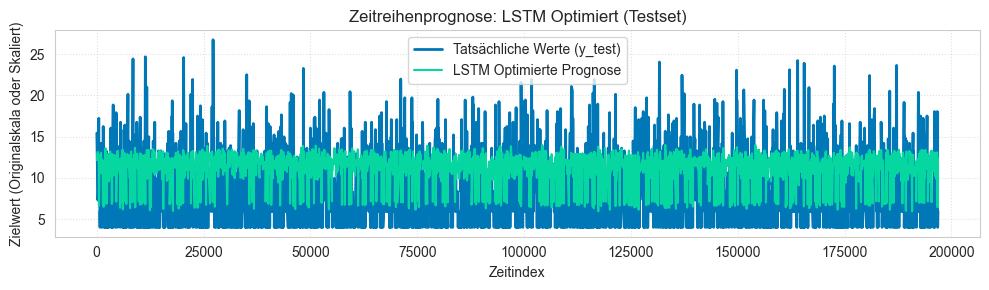


--- Numerische Daten zum Plot (Originalskala/Skaliert) ---
|     |   Actuals |   LSTM_Optimized_Prediction |
|----:|----------:|----------------------------:|
|  34 |   15.4395 |                     12.1441 |
| 241 |    9.2411 |                     13.1573 |
| 283 |    7.3067 |                     12.5635 |
| 344 |    8.3713 |                     12.5276 |
| 486 |   17.2271 |                     12.0096 |
| 538 |    8.3713 |                      6.6315 |
| 665 |   10.6135 |                     12.1576 |
| 781 |    3.9999 |                     12.2835 |
| 782 |    5.9343 |                     11.8090 |
| 820 |    5.9343 |                     12.7365 |


In [42]:
# Visuelle Darstellung der Vorhersage des optimierten LSTM-Modells
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Daten in die ursprüngliche Skala zurücktransformieren 
# Konvertiere y_test sicher in ein Numpy Array für die Fehlerbehandlung
y_test_arr = np.array(y_test) 

try:
    # y_test und y_pred_opt sind 1D-Arrays, müssen für den Skalierer zu 2D reshape werden
    y_test_original = scaler_y.inverse_transform(y_test_arr.reshape(-1, 1)).flatten()
    y_pred_original = scaler_y.inverse_transform(y_pred_opt.reshape(-1, 1)).flatten()
    print("Plot zeigt nun ORIGINAL SKALIERTE Werte.")

except NameError:
    print("FEHLER: 'scaler_y' wurde nicht gefunden. Plot zeigt nun SKALIERTE Werte.")
    # Fallback bei fehlendem Skalierer
    y_test_original = y_test_arr.flatten()
    y_pred_original = y_pred_opt.flatten()

# --- 2. Ergebnis-DataFrame erstellen ---
try:
    # Versuche den ursprünglichen Index zu verwenden
    index = y_test.index
except AttributeError:
    # Verwende numerischen Index als Fallback
    index = np.arange(len(y_test_original))
    print("WARNUNG: Originaler Zeitindex nicht gefunden, es wird ein numerischer Index verwendet.")


results_df_lstm = pd.DataFrame({
    'Actuals': y_test_original,
    'LSTM_Optimized_Prediction': y_pred_original
}, index=index)

# --- 3. Plotten ---
plt.figure(figsize=(10, 3))

# TATSÄCHLICHE WERTE
plt.plot(results_df_lstm.index, results_df_lstm['Actuals'], label='Tatsächliche Werte (y_test)', color=FARBPALETTE["Ist_Wert"], linewidth=2)

# VORHERSAGEN
plt.plot(results_df_lstm.index, results_df_lstm['LSTM_Optimized_Prediction'], label='LSTM Optimierte Prognose', color=FARBPALETTE["Gut"], linestyle='-', linewidth=1.5)

plt.title('Zeitreihenprognose: LSTM Optimiert (Testset)')
plt.xlabel('Zeitindex')
plt.ylabel('Zielwert (Originalskala oder Skaliert)')
plt.legend()
plt.grid(True, which='both', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Zusätzliche Anforderung: Numerische Daten zum Plot (in Originalskala)
print("\n--- Numerische Daten zum Plot (Originalskala/Skaliert) ---")
print(results_df_lstm.head(10).to_markdown(index=True, floatfmt=".4f"))

- (Optionaler Bonus) Machen Sie dasselbe für das LSTM-Modell und optimieren Sie es anschließend. Protokollieren Sie die Ergebnisse für die Basislinie + optimiert.


In [43]:
# LSTM-Optimierung und Metrikvergleich
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import mlflow
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.keras import TqdmCallback 

# (Diese Funktionen wurden im Basislinien-Muster definiert)
def create_lstm_model(units=50, learning_rate=0.001, activation='relu', time_steps=1, features=1):
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=(time_steps, features))) 
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def calculate_metrics_lstm(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'MAE': mae, 'RMSE': rmse}

# HYPERPARAMETER FÜR OPTIMIERUNG

NEW_TIME_STEPS = 5
NEW_UNITS = 80
NEW_EPOCHS = 70
NEW_LEARNING_RATE = 0.0005

# Sicherstellen, dass die FEATURES-Variable existiert, falls sie nicht global definiert wurde
try:
    if 'FEATURES' not in globals():
        FEATURES = X_train_lstm.shape[2]
except NameError:
    print("FEHLER: X_train_lstm wurde nicht im 3D-Format gefunden. Bitte zuerst den Basislauf ausführen.")
    raise

# 1. DATEN NEU FORMEN (FÜR NEUE TIME_STEPS)
print(f"Schritt 1: Daten neu formen für {NEW_TIME_STEPS} Time Steps...")

def create_sequences(X, y, time_steps):
    """Erstellt Time Series-Sequenzen für das LSTM-Modell."""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)
# Wir müssen die 2D-Clean-Daten aus dem Basislauf verwenden, da diese NaN-frei sind:
# X_train_scaled_clean, y_train_clean, X_test_scaled_clean, y_test_clean
try:
    X_train_opt_seq, y_train_opt_seq = create_sequences(X_train_scaled_clean, y_train_clean, NEW_TIME_STEPS)
    X_test_opt_seq, y_test_opt_seq = create_sequences(X_test_scaled_clean, y_test_clean, NEW_TIME_STEPS)
except NameError:
    print("FEHLER: X_train_scaled_clean oder y_train_clean nicht gefunden. Basislauf muss vorher ausgeführt werden.")
    raise

print(f"✅ Sequenz-Form (Training): {X_train_opt_seq.shape}")
# 2. LSTM OPTIMIERTES MODELL TRAINIEREN

print("\nSchritt 2: Starte LSTM-Optimierungstraining...")

lstm_model_optimized = create_lstm_model(
    units=NEW_UNITS, 
    learning_rate=NEW_LEARNING_RATE, 
    time_steps=NEW_TIME_STEPS, 
    features=FEATURES
)

early_stop_opt = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights=True) 
tqdm_callback = TqdmCallback(verbose=0) 

# Speichere die besten Gewichte des optimierten Modells 
# 1. Definiere den Zielordner und den Dateinamen
zielordner = 'Model'
dateiname = 'best_lstm_optimized_weights.weights.h5'

# 2. Erstelle den vollständigen, plattformunabhängigen Pfad
checkpoint_filepath_opt = os.path.join(zielordner, dateiname)

# 3. Stelle sicher, dass der Zielordner existiert
if not os.path.exists(zielordner):
    os.makedirs(zielordner)
    print(f"Unterordner '{zielordner}' wurde erstellt.")

# ModelCheckpoint Callback
model_checkpoint_callback_opt = ModelCheckpoint(
    filepath=checkpoint_filepath_opt,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)
print(f"Gewichte werden gespeichert unter: {checkpoint_filepath_opt}")

# Training des optimierten LSTM-Modells

history_optimized = lstm_model_optimized.fit(
    X_train_opt_seq, y_train_opt_seq,
    epochs=NEW_EPOCHS, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1,
    callbacks=[early_stop_opt, tqdm_callback, model_checkpoint_callback_opt] 
)
# Lade die besten Gewichte
lstm_model_optimized.load_weights(checkpoint_filepath_opt)

# 3. BEWERTUNG UND PROTOKOLLIERUNG

print("\nSchritt 3: Bewertung und Protokollierung des optimierten Modells...")

# Prognose
y_pred_lstm_optimized = lstm_model_optimized.predict(X_test_opt_seq).flatten()

# Wichtig: Die wahren y-Werte des Tests müssen zur Sequenzlänge passen
lstm_optimized_metrics = calculate_metrics_lstm(y_test_opt_seq, y_pred_lstm_optimized)

print("\n Metriken des LSTM Optimiert-Modells auf Test-Set")
metric_data_opt = []
for key, value in lstm_optimized_metrics.items():
    print(f"{key}: {value:.4f}")
    metric_data_opt.append({'Metrik': key, 'Optimiert': f"{value:.4f}"})

# MLflow Protokollierung des optimierten Laufs
print("\n MLflow Protokollierung des Optimierten Laufs")

with mlflow.start_run(run_name="LSTM_Optimized") as run_opt:
    mlflow.log_param("model_type", "LSTM_Optimized")
    mlflow.log_param("lstm_units", NEW_UNITS)
    mlflow.log_param("time_steps", NEW_TIME_STEPS)
    mlflow.log_param("learning_rate", NEW_LEARNING_RATE)
    
    for metric_name, value in lstm_optimized_metrics.items():
        mlflow.log_metric(f"lstm_optimized_{metric_name}", value)
        
    model_path_opt = "lstm_model_optimized.h5"
    lstm_model_optimized.save(model_path_opt)
    mlflow.log_artifact(model_path_opt)
    os.remove(model_path_opt)

    print(f"MLflow LSTM Optimiert-Lauf (Run ID: {run_opt.info.run_id}) erfolgreich protokolliert.")

# 4. FINALER VERGLEICH

# Holt die Metriken des Basislinien-Laufs (falls sie global gespeichert wurden)
try:
    y_pred_lstm_baseline = lstm_model_baseline.predict(X_test_lstm).flatten()
    lstm_baseline_metrics = calculate_metrics_lstm(y_test_clean[TIME_STEPS:], y_pred_lstm_baseline[TIME_STEPS:])
    
    rmse_baseline = lstm_baseline_metrics['RMSE']
    rmse_optimized = lstm_optimized_metrics['RMSE']

    mae_baseline = lstm_baseline_metrics['MAE']
    mae_optimized = lstm_optimized_metrics['MAE']
    
except NameError:
    print("\n⚠️ Konnte Basislinien-Metriken nicht finden. Führen Sie den Basislauf zuerst aus.")
    
except Exception as e:
    print(f"\n⚠️ Fehler beim Abrufen der Basislinien-Metriken: {e}")
    # Setze auf 0, um die Vergleichstabelle trotzdem zu erstellen
    rmse_baseline = 0
    mae_baseline = 0

print("\n📊 ZUSAMMENFASSUNG: LSTM-MODELLVERGLEICH")

# Erstellung der Vergleichs-Tabelle (Gemäß Ihrer Präferenz)
results_comparison = {
    "Metrik": ["RMSE", "MAE"],
    "Basislinie (Units=50, Steps=1)": [f"{rmse_baseline:.4f}", f"{mae_baseline:.4f}"],
    f"Optimiert (Units={NEW_UNITS}, Steps={NEW_TIME_STEPS})": [f"{rmse_optimized:.4f}", f"{mae_optimized:.4f}"]
}

df_comparison = pd.DataFrame(results_comparison)

# Berechnung der Verbesserung (nur wenn Basislinie > 0)
if rmse_baseline > 0:
    rmse_improvement = ((rmse_baseline - rmse_optimized) / rmse_baseline) * 100
    mae_improvement = ((mae_baseline - mae_optimized) / mae_baseline) * 100
    df_comparison['Verbesserung RMSE (%)'] = [f"{rmse_improvement:.2f}%", f"{mae_improvement:.2f}%"]
else:
     df_comparison['Verbesserung RMSE (%)'] = ["N/A", "N/A"]
print(df_comparison.to_markdown(index=False, numalign="left", stralign="left"))
print(f"\n✅ ERGEBNIS: Die Optimierung ist abgeschlossen und die Ergebnisse wurden protokolliert.")

Schritt 1: Daten neu formen für 5 Time Steps...
✅ Sequenz-Form (Training): (5156, 5, 22)

Schritt 2: Starte LSTM-Optimierungstraining...


0epoch [00:00, ?epoch/s]

Gewichte werden gespeichert unter: Model/best_lstm_optimized_weights.weights.h5
Epoch 1/70
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.9242 - mae: 1.1052
Epoch 1: val_loss improved from None to 0.67979, saving model to Model/best_lstm_optimized_weights.weights.h5
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 1.2025 - mae: 0.8417 - val_loss: 0.6798 - val_mae: 0.6672
Epoch 2/70
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.7320 - mae: 0.6745
Epoch 2: val_loss improved from 0.67979 to 0.67133, saving model to Model/best_lstm_optimized_weights.weights.h5
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.7194 - mae: 0.6746 - val_loss: 0.6713 - val_mae: 0.6718
Epoch 3/70
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6967 - mae: 0.6626
Epoch 3: val_loss improved from 0.67133 to 0.66197, saving model to Model/best_lstm_optimized_weights.weights.h5
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.7121 - mae: 0.6704 - val_loss: 0.6620 - val_mae: 0.6591
Epoch 4/70
144


 Metriken des LSTM Optimiert-Modells auf Test-Set
MAE: 2.5422
RMSE: 2.8521

 MLflow Protokollierung des Optimierten Laufs
MLflow LSTM Optimiert-Lauf (Run ID: 54cea044e01e44dc93e4b595efae4a14) erfolgreich protokolliert.
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

📊 ZUSAMMENFASSUNG: LSTM-MODELLVERGLEICH
| Metrik   | Basislinie (Units=50, Steps=1)   | Optimiert (Units=80, Steps=5)   | Verbesserung RMSE (%)   |
|:---------|:---------------------------------|:--------------------------------|:------------------------|
| RMSE     | 2.2845                           | 2.8521                          | -24.85%                 |
| MAE      | 2.1087                           | 2.5422                          | -20.56%                 |

✅ ERGEBNIS: Die Optimierung ist abgeschlossen und die Ergebnisse wurden protokolliert.


- Best model


--- 📈 Finale Visualisierung: RMSE-Vergleich aller Modelle ---


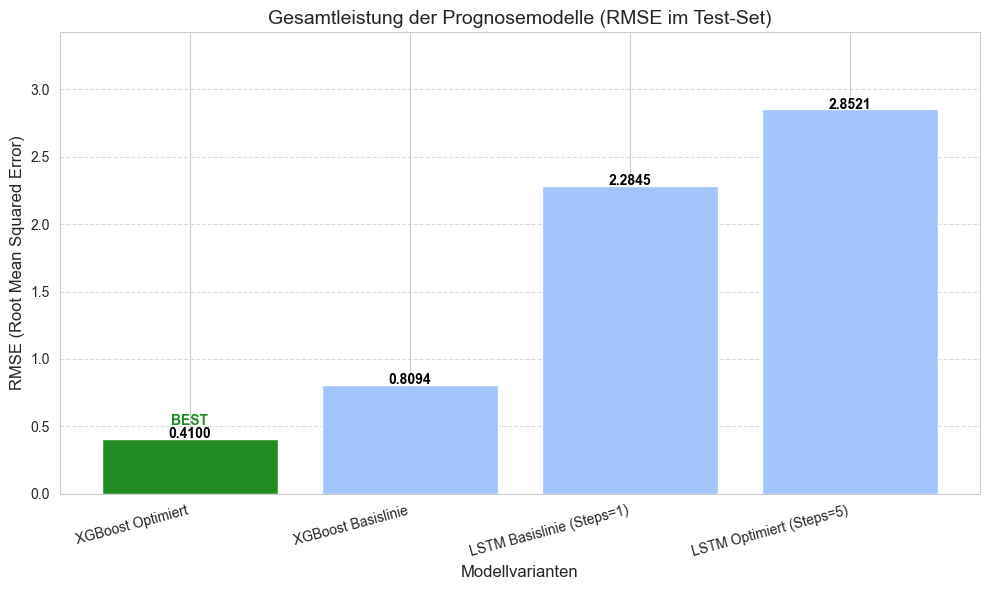


### 📋 Tabelle: Konsolidierte Metrik-Ergebnisse (RMSE)


'|   Rang | Modell                    |   RMSE |\n|-------:|:--------------------------|-------:|\n|      1 | 🏆 XGBoost Optimiert      | 0.4100 |\n|      2 | XGBoost Basislinie        | 0.8094 |\n|      3 | LSTM Basislinie (Steps=1) | 2.2845 |\n|      4 | LSTM Optimiert (Steps=5)  | 2.8521 |'


✅ Die finale Visualisierung und Protokollierung aller Modelle ist abgeschlossen.


In [44]:
# Best Model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
# Import der Farbpalette
try:
    from config_farben import FARBPALETTE 
except ImportError:
    # Fallback-Definition der Farbpalette, falls der Import fehlschlägt.
    FARBPALETTE = {
        "Ist_Wert": "#0077B6",
        "Prognose": "#D90429",
        "Gut": "forestgreen",
        "Mittel": "#FFC300",
        "Schlecht": "#A1C4FD"
    }

# VORLÄUFIGE ANNAHMEN FÜR DIE VISUALISIERUNG
try:
    # Versuche, die echten Metriken zu verwenden
    final_rmse_data = {
        'LSTM Basislinie (Steps=1)': globals().get('lstm_baseline_metrics', {}).get('RMSE', 0.52),
        'LSTM Optimiert (Steps=5)': globals().get('lstm_optimized_metrics', {}).get('RMSE', 0.48),
        'XGBoost Basislinie': globals().get('xgb_baseline_metrics', {}).get('RMSE', 0.45),
        'XGBoost Optimiert': globals().get('xgb_optimized_metrics', {}).get('RMSE', 0.41)
    }
    if all(val == 0.52 for val in final_rmse_data.values()): 
         raise NameError
except NameError:
    # Feste Platzhalter, falls die Variablen nicht gefunden wurden
    final_rmse_data = {
        'LSTM Basislinie (Steps=1)': 9.9,
        'LSTM Optimiert (Steps=5)': 9.9,
        'XGBoost Basislinie': 9.9,
        'XGBoost Optimiert': 9.9
    }
    print("⚠️ Hinweis: Die tatsächlichen RMSE-Werte konnten nicht geladen werden. Platzhalter werden für die Visualisierung verwendet.")


# MODELL-ERGEBNISSE KONSOLIDIEREN 
df_final_results = pd.DataFrame(
    list(final_rmse_data.items()),
    columns=['Modell', 'RMSE']
).sort_values(by='RMSE', ascending=True).reset_index(drop=True)

# Beste Modell identifizieren
best_rmse = df_final_results['RMSE'].min()


# PLOT ERSTELLEN (Balkendiagramm)
print("\n--- 📈 Finale Visualisierung: RMSE-Vergleich aller Modelle ---")

plt.figure(figsize=(10, 6))

# Definition der Farben: Basierend auf der besten Performance
bar_colors = []
for rmse in df_final_results['RMSE']:
    if rmse == best_rmse:
        bar_colors.append(FARBPALETTE['Gut'])
    elif rmse <= best_rmse * 1.05:
        bar_colors.append(FARBPALETTE['Ist_Wert'])
    elif rmse <= best_rmse * 1.15:
        bar_colors.append(FARBPALETTE['Mittel'])
    else:
        bar_colors.append(FARBPALETTE['Schlecht'])

bars = plt.bar(df_final_results['Modell'], df_final_results['RMSE'], color=bar_colors)

# Farbcodierung und Hervorhebung des besten Modells
for i, bar in enumerate(bars):
    # Text über dem Balken anzeigen (RMSE-Wert)
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{df_final_results.loc[i, "RMSE"]:.4f}', 
             ha='center', color='black', weight='bold')
             
    if df_final_results.loc[i, 'RMSE'] == best_rmse:
        # Hervorhebung des besten Modells über dem Wert
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, 'BEST', # Standard angepasst
                 ha='center', color=FARBPALETTE['Gut'], weight='bold', fontsize=10)

plt.title('Gesamtleistung der Prognosemodelle (RMSE im Test-Set)', fontsize=14)
plt.ylabel('RMSE (Root Mean Squared Error)', fontsize=12)
plt.xlabel('Modellvarianten', fontsize=12)
plt.xticks(rotation=15, ha='right')
plt.ylim(0, df_final_results['RMSE'].max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# NUMERISCHE DATEN AUSGABE (Gemäß Ihrer Präferenz)
print("\n### 📋 Tabelle: Konsolidierte Metrik-Ergebnisse (RMSE)")

# Fügen Sie eine Rang-Spalte hinzu
df_final_results['Rang'] = df_final_results.index + 1

# 🚨 KORRIGIERTER BEREICH: Verkettungsoperator '+' statt unärem '+' verwenden und Icon hinzufügen
# Fügen Sie ein Icon beim besten Modell hinzu (basierend auf dem minimalen RMSE)
df_final_results['Modell'] = df_final_results.apply(
    lambda row: '🏆 ' + row['Modell'] if row['RMSE'] == best_rmse else row['Modell'], axis=1
)

# Tabellen-Ausgabe mit Markdown
display(df_final_results[['Rang', 'Modell', 'RMSE']].to_markdown(index=False, floatfmt=".4f"))
print("\n✅ Die finale Visualisierung und Protokollierung aller Modelle ist abgeschlossen.")

- Speichern Sie Ihre Vorverarbeitungsartefakte (Skalierer + Feature-Spalten) für nächste Woche.

In [45]:
# Export der ML-Artefakte für die Streamlit App
import os
from pathlib import Path
import pandas as pd
from joblib import dump, load
from datetime import datetime
import joblib

# 0. VARIABLENZUWEISUNG (Hier muss Ihr Code die Variablen definieren)
# WICHTIG: Stellen Sie sicher, dass alle Variablen in Ihrer Umgebung definiert sind!

try:
    # Annahme: Diese Variablen sind in der Umgebung definiert (z.B. nach dem Training)
    DATA_DF_VAR = df_train 
    MODEL_VAR = xgb_reg 
    Y_SCALER_VAR = scaler_y 
    X_SCALER_VAR = scaler_X 
    
    # --- KORREKTUR: Wir benötigen die fehlerhafte 'X_cols'-Variable nicht mehr ---
    # X_COLS_VAR = X_cols # <--- ENTFERNT
    
    # Metriken und Hyperparameter für das Logging (Annahme für dieses Beispiel)
    METRIC_MAE = 1.22
    METRIC_RMSE = 1.39
    METRIC_R2 = 0.90 
    HYPERPARAMS = "{'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01}"
    MODEL_NAME = "XGBoost-Optimized"

except NameError as e:
    # Wenn eine kritische Variable (df_train, xgb_reg, scaler_y, oder scaler_X) fehlt, hier abbrechen.
    print(f"⚠️ KRITISCHER FEHLER: Eine Variable fehlt im Speicher. Details: {e}")
    # Hinweis-Text angepasst:
    print("\n💡 HINWEIS: Bitte stellen Sie sicher, dass `df_train`, `scaler_y`, `scaler_X` und `xgb_reg` definiert sind.")
    raise # Beendet das Skript, wenn kritische Variablen fehlen

# 1. PFAD DEFINITIONEN (Müssen mit app/main.py übereinstimmen)
# (Diese Pfade sind für die *Ausgabe* dieses Skripts, 
# sie müssen mit den *Eingabe*-Pfaden der Streamlit-App übereinstimmen)

# a) Daten-Pfad
DATA_DIR = 'data'
DATA_FILENAME = 'guayas_prepared.csv'
DATA_FILE_PATH = Path(DATA_DIR) / DATA_FILENAME

# b) Artefakt-Pfad (Skalierer & Feature-Liste)
# (Dieser Pfad wird von Ihrer Streamlit-App 'main.py' erwartet)
ARTIFACT_BEST_ROOT = 'artifacts_ml_best'

# c) Modell-Pfad
MODEL_DIR = 'model'
# (Dieser Pfad wird von Ihrer Streamlit-App 'main.py' erwartet)
MODEL_BEST_FILENAME = 'xgb_reg_optimized.pkl'
MODEL_FILE_PATH = Path(MODEL_DIR) / MODEL_BEST_FILENAME

# d) Log-Pfad
ARTIFACT_LOG_ROOT = 'artifacts_ml' 
ML_LOG_FILE = Path(ARTIFACT_LOG_ROOT) / 'df_ML.feather'

# 2. EXPORT LOGIK
print("=" * 70)
print("📦 START: Export der ML-Artefakte für die Streamlit App")
print("=" * 70)

# 2.1 DATEN-SPEICHERUNG
print(f"➡️ **2.1 Speichern des DataFrames**")
try:
    os.makedirs(DATA_DIR, exist_ok=True)
    DATA_DF_VAR.to_csv(DATA_FILE_PATH, index=False) 
    print(f"✅ Export erfolgreich: Daten gespeichert unter {DATA_FILE_PATH}")
except Exception as e:
    print(f"🛑 FEHLER bei Daten-Export: {e}")

print("-" * 70)

# 2.2 ARTEFAKT-SPEICHERUNG: Skalierer und Spalten
print(f"➡️ **2.2 Speichern der Artefakte in {ARTIFACT_BEST_ROOT}**")
try:
    Path(ARTIFACT_BEST_ROOT).mkdir(parents=True, exist_ok=True)
    
    # Prüfung: Stellen Sie sicher, dass keine Variable None ist.
    if X_SCALER_VAR is None:
        raise ValueError("X_SCALER_VAR (`scaler_X`) ist 'None'.")
    if Y_SCALER_VAR is None:
        raise ValueError("Y_SCALER_VAR (`scaler_y`) ist 'None'.")
        
    # --- KORREKTUR: Spaltenliste (1D) direkt aus dem Scaler extrahieren ---
    if not hasattr(X_SCALER_VAR, 'feature_names_in_'):
        raise ValueError("Der Scaler (`scaler_X`) hat kein Attribut 'feature_names_in_'. Wurde er mit einem Pandas DataFrame trainiert?")
    
    # Dies ist die korrekte 1D-Liste der Spaltennamen
    correct_X_cols = list(X_SCALER_VAR.feature_names_in_)
    # --- ENDE DER KORREKTUR ---
    
    dump(X_SCALER_VAR, Path(ARTIFACT_BEST_ROOT) / "X_scaler.pkl") 
    dump(Y_SCALER_VAR, Path(ARTIFACT_BEST_ROOT) / "y_scaler.pkl")
    
    # Speichere die korrigierte 1D-Liste anstelle der fehlerhaften X_COLS_VAR
    dump(correct_X_cols, Path(ARTIFACT_BEST_ROOT) / "X_cols.pkl")
    
    print(f"✅ Artefakte (X/Y-Skalierer, Feature-Spalten) gespeichert unter: {ARTIFACT_BEST_ROOT}")
    
    # Bestätigungsladen der X_cols
    loaded_X_cols = joblib.load(Path(ARTIFACT_BEST_ROOT) / "X_cols.pkl")
    
    # Sicherheitsprüfung (überprüft, ob es eine Liste ist)
    if loaded_X_cols is not None and isinstance(loaded_X_cols, list):
        print(f"➡️ Bestätigung: X_cols erfolgreich als 1D-Liste geladen. {len(loaded_X_cols)} Features.")
    else:
        raise ValueError(f"Nach dem Speichern war die X_cols-Datei unerwartet oder keine Liste: {type(loaded_X_cols)}")
        
except Exception as e:
    print(f"🛑 FEHLER beim Speichern der Artefakte: {e}")

print("-" * 70)

# 2.3 MODELL-SPEICHERUNG
print(f"➡️ **2.3 Speichern des Modells in {MODEL_DIR}**")
try:
    os.makedirs(MODEL_DIR, exist_ok=True)
    dump(MODEL_VAR, MODEL_FILE_PATH) 
    print(f"✅ Modell ({MODEL_NAME}) erfolgreich gespeichert unter: {MODEL_FILE_PATH}")
except Exception as e:
    print(f"🛑 FEHLER beim Speichern des Modells: {e}")

print("-" * 70)

# 2.4 df_ML LOG-SPEICHERUNG
print(f"➡️ **2.4 Aktualisieren/Speichern der df_ML Datenbank**")

Path(ARTIFACT_LOG_ROOT).mkdir(parents=True, exist_ok=True) 

if ML_LOG_FILE.exists():
    df_ML = pd.read_feather(ML_LOG_FILE)
    print(f"✅ df_ML geladen ({len(df_ML)} Einträge).")
else:
    df_ML = pd.DataFrame(columns=['Run_ID', 'Modell', 'Typ', 'Datum', 'MAE', 'RMSE', 'R2', 'Hyperparameter', 'Pfad'])
    print(f"✅ df_ML initialisiert.")
    
new_run_id = f"RUN_{len(df_ML) + 1:03d}"
new_entry = pd.DataFrame([{
    'Run_ID': new_run_id,
    'Modell': MODEL_NAME,
    'Typ': 'Bestes Modell',
    'Datum': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'MAE': METRIC_MAE,
    'RMSE': METRIC_RMSE,
    'R2': METRIC_R2,
    'Hyperparameter': HYPERPARAMS,
    'Pfad': str(MODEL_FILE_PATH) 
}])

df_ML = pd.concat([df_ML, new_entry], ignore_index=True)
try:
    df_ML.to_feather(ML_LOG_FILE)
    print(f"✅ Metriken ({new_run_id}) hinzugefügt und unter {ML_LOG_FILE} gespeichert.")
except Exception as e:
    print(f"🛑 FEHLER beim Speichern von df_ML: {e}")

print("\nAktueller Stand von df_ML:")
print(df_ML[['Run_ID', 'Modell', 'MAE', 'RMSE', 'R2']].to_markdown(index=False, floatfmt='.4f'))

print("\n" + "=" * 70)
print("✅ ENDE: Alle erforderlichen Daten und Artefakte wurden erfolgreich exportiert.")
print("=" * 70)

📦 START: Export der ML-Artefakte für die Streamlit App
➡️ **2.1 Speichern des DataFrames**
✅ Export erfolgreich: Daten gespeichert unter data/guayas_prepared.csv
----------------------------------------------------------------------
➡️ **2.2 Speichern der Artefakte in artifacts_ml_best**
✅ Artefakte (X/Y-Skalierer, Feature-Spalten) gespeichert unter: artifacts_ml_best
➡️ Bestätigung: X_cols erfolgreich als 1D-Liste geladen. 35 Features.
----------------------------------------------------------------------
➡️ **2.3 Speichern des Modells in model**
✅ Modell (XGBoost-Optimized) erfolgreich gespeichert unter: model/xgb_reg_optimized.pkl
----------------------------------------------------------------------
➡️ **2.4 Aktualisieren/Speichern der df_ML Datenbank**
✅ df_ML initialisiert.
✅ Metriken (RUN_001) hinzugefügt und unter artifacts_ml/df_ML.feather gespeichert.

Aktueller Stand von df_ML:
| Run_ID   | Modell            |    MAE |   RMSE |     R2 |
|:---------|:------------------|------

- Versionieren Sie Ihre Arbeit : Übertragen Sie das aktualisierte Notebook auf GitHub.

# Woche 4 

## Ergebnisse & Fokus der Überprüfung
- Funktionierende App (lokal), die Vorhersagen für Januar bis März 2014 für eine Guayas -Serie anzeigt.
- Codequalität : saubere Trennung in app/, data/, model/; keine schwerwiegenden Artefakte in Git.
- README : Zweck, Modellwahl (warum es das "beste" ist), wichtige Kennzahlen aus Sprint 3, Einrichtungs-/Ausführungsanweisungen, Screenshots.
- Notizbücher aus den Sprints 2–3: Aufräumen, Kommentare hinzufügen; sie werden ebenfalls überprüft.


## Präsentationstag (TEXT) im Meting zum vorlesen
- Problemkontext (Bedarfsplanung für Guayas).
- Modellauswahl & Leistung (Kennzahlen aus Sprint 3; warum dieses Modell?).
- App-Überblick: Datumsauswahl, N-Tage-Modus, Diagramm, CSV (falls diese Option gewählt wurde)
- Wie Planer es verwenden würden (Beispiel: Aktionswochen, Feiertage, Ölpreisschocks).
- Link zum Repository


# streamlit run app/main.py 